Cleveland Dataset Analysis:

Cleveland Dataset Basic Information:
Number of records: 303
Number of features: 14

First 5 rows:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       2  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0  

Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

Descriptive Statistic

<Figure size 1500x1000 with 0 Axes>

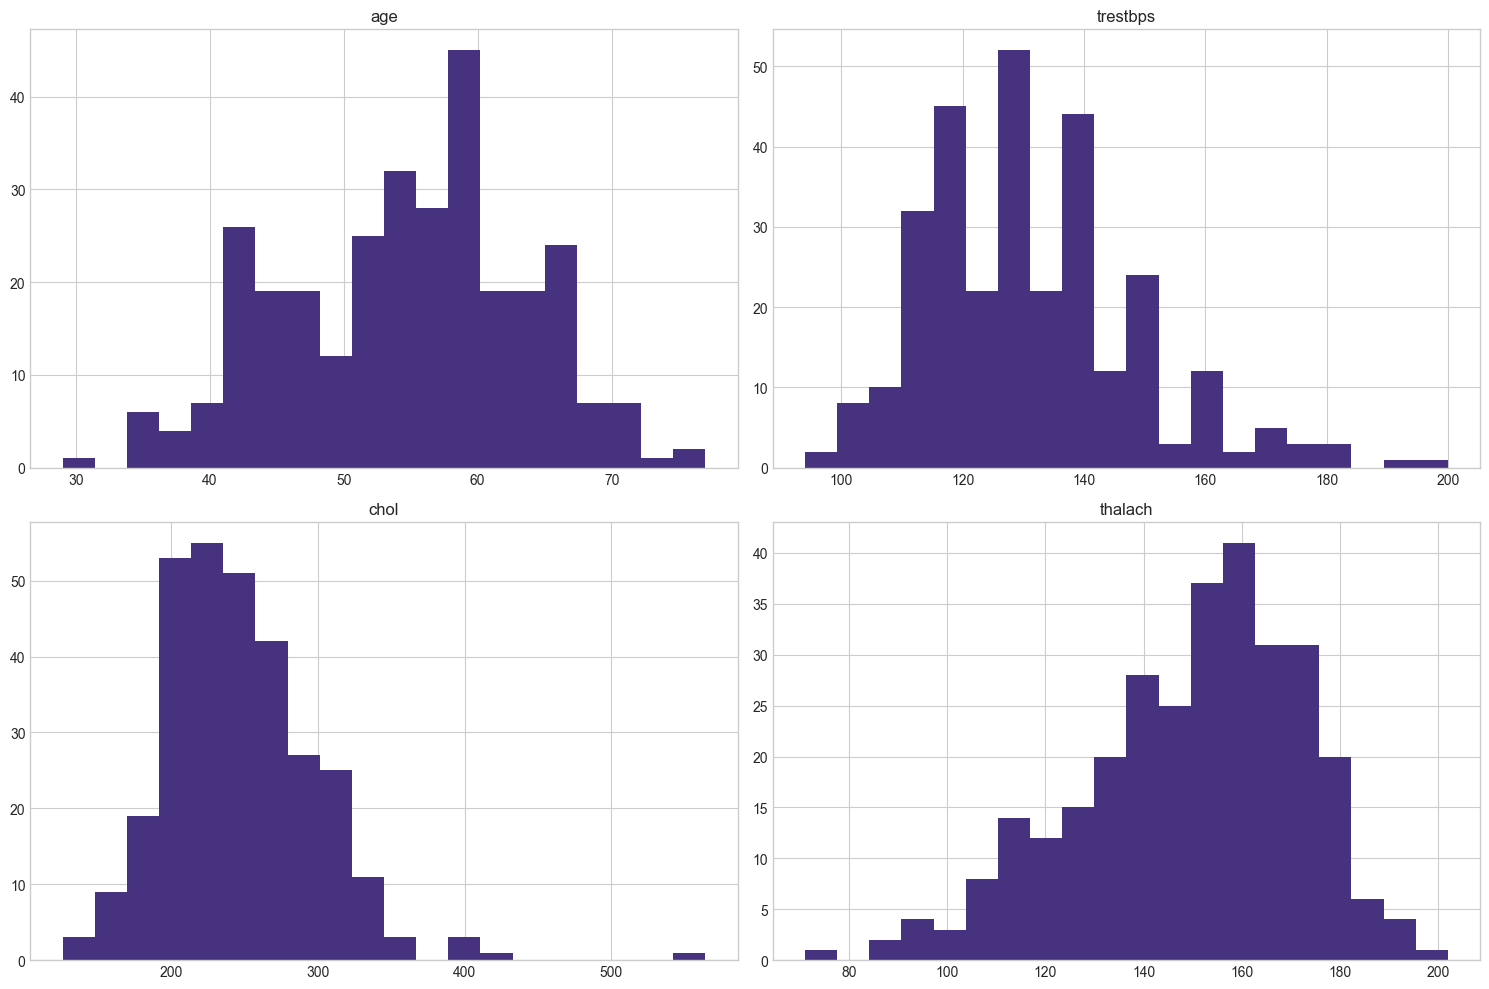

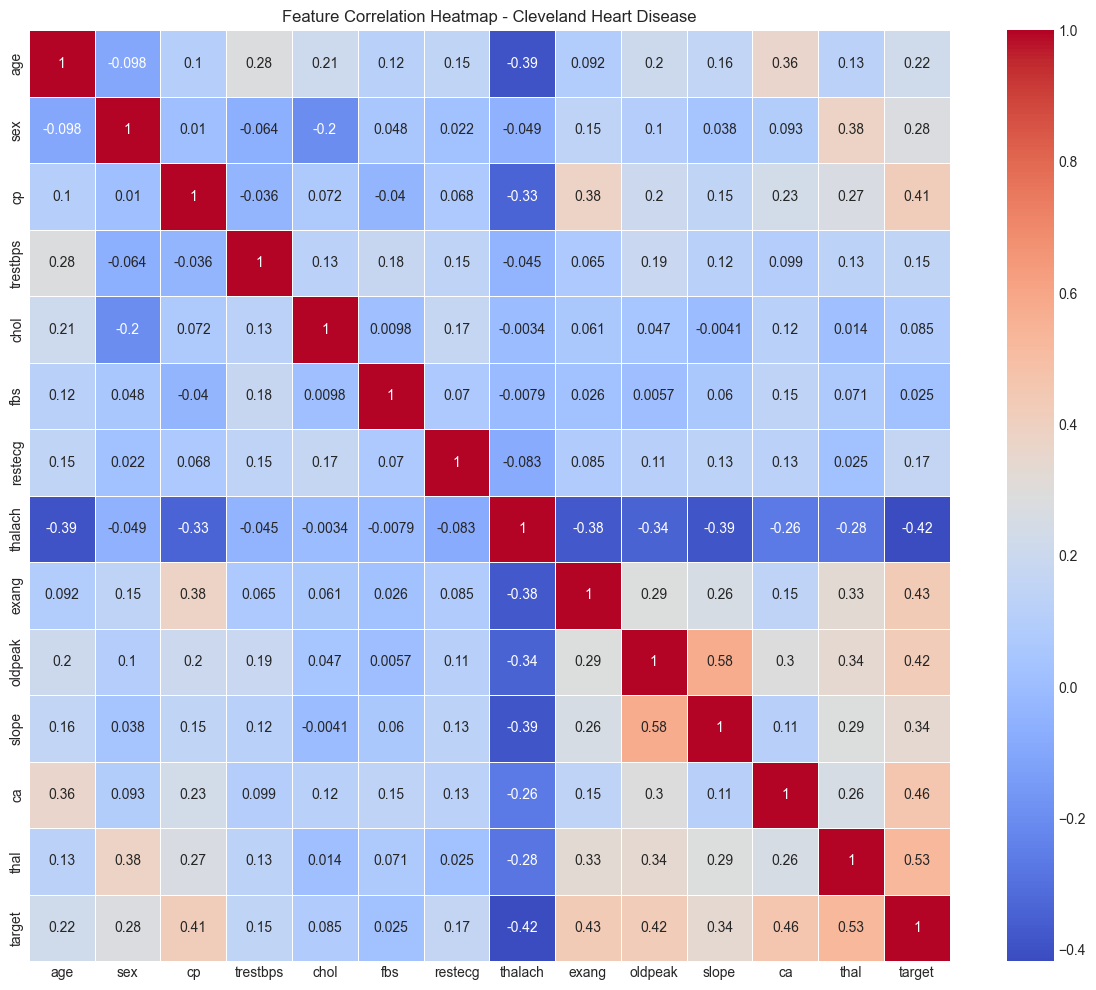

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# Define the path to the Cleveland dataset
cleveland_path = '/Users/andrechu/Desktop/UnivUtah/BMI6106/Project/heart+disease/processed.cleveland.data'

# Define column names for the Cleveland dataset based on documentation
column_names = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]

# Load the Cleveland dataset
# The file is space-separated, and missing values are denoted by '?'
try:
    # First try comma-separated format
    cleveland_df = pd.read_csv(cleveland_path, names=column_names, na_values='?')
except:
    try:
        # If that fails, try space-separated format
        cleveland_df = pd.read_csv(cleveland_path, names=column_names, delim_whitespace=True, na_values='?')
    except Exception as e:
        print(f"Error loading Cleveland dataset: {e}")
        # Create a dummy dataframe for testing if loading fails
        cleveland_df = pd.DataFrame(columns=column_names)

# Print basic dataset information
print("Cleveland Dataset Basic Information:")
print(f"Number of records: {len(cleveland_df)}")
print(f"Number of features: {len(cleveland_df.columns)}")
print("\nFirst 5 rows:")
print(cleveland_df.head())

# Check for missing values
print("\nMissing values per column:")
print(cleveland_df.isnull().sum())

# Convert target to binary (in case it has multiple classes)
if not cleveland_df.empty:
    # If target has values > 1, convert to binary (0 = no disease, 1 = disease)
    if cleveland_df['target'].max() > 1:
        cleveland_df['target'] = cleveland_df['target'].apply(lambda x: 1 if x > 0 else 0)
    
    # Print descriptive statistics
    print("\nDescriptive Statistics:")
    print(cleveland_df.describe())
    
    # Analyze target variable distribution
    print("\nTarget Variable Distribution:")
    target_counts = cleveland_df['target'].value_counts()
    print(target_counts)
    print(f"Percentage with heart disease: {target_counts[1] / len(cleveland_df) * 100:.2f}%")
    
    # Analyze correlations between features and target
    print("\nCorrelations with Target Variable:")
    correlations = cleveland_df.corr()['target'].sort_values(ascending=False)
    print(correlations)
    
    # Save important variables for cross-dataset validation
    key_features = ['age', 'sex', 'trestbps', 'chol', 'thalach', 'target']
    cleveland_key_df = cleveland_df[key_features]
    print("\nKey features for cross-dataset validation:")
    print(cleveland_key_df.head())
    
    # Generate visualizations for key features
    print("\nGenerating visualizations (these will be saved to disk)...")
    
    # Histograms of numerical features
    plt.figure(figsize=(15, 10))
    cleveland_df[['age', 'trestbps', 'chol', 'thalach']].hist(bins=20, figsize=(15, 10))
    plt.tight_layout()
    plt.savefig('cleveland_histograms.png')
    
    # Correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(cleveland_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Feature Correlation Heatmap - Cleveland Heart Disease')
    plt.tight_layout()
    plt.savefig('cleveland_correlation.png')
    
    print("Visualizations saved.")
else:
    print("No data available for visualizations.")

print("\nCleveland dataset analysis complete.")

MIMIC-4 Dataset Analysis:

In [19]:
import pandas as pd
import numpy as np
import json
import gzip
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Define the base path to the MIMIC-IV FHIR dataset
mimic_base_path = '/Users/andrechu/Desktop/UnivUtah/BMI6106/Project/MIMIC-IV/physionet.org/files/mimic-iv-fhir/2.1/fhir/'

# Define the file paths for key MIMIC-IV files
patient_file = os.path.join(mimic_base_path, 'MimicPatient.ndjson.gz')
condition_file = os.path.join(mimic_base_path, 'MimicCondition.ndjson.gz')
vitals_file = os.path.join(mimic_base_path, 'MimicObservationVitalSignsED.ndjson.gz')
lab_file = os.path.join(mimic_base_path, 'MimicObservationLabevents.ndjson.gz')
encounter_file = os.path.join(mimic_base_path, 'MimicEncounter.ndjson.gz')

# Function to read the first n lines from a gzipped ndjson file
def read_ndjson_sample(file_path, n=10):
    """Read first n lines from a gzipped ndjson file and return as a list of dictionaries."""
    data = []
    try:
        with gzip.open(file_path, 'rt') as file:
            for i, line in enumerate(file):
                if i >= n:
                    break
                data.append(json.loads(line))
        return data
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return []

# Function to extract patient demographics
def extract_patient_data(patients_data, n=1000):
    """Extract key demographic information from patient data."""
    current_year = 2025  # Based on your document
    
    patient_records = []
    for patient in patients_data[:n]:
        try:
            # Extract patient ID
            patient_id = patient.get('id', '')
            
            # Extract birth date and calculate age
            birth_date = patient.get('birthDate', '')
            age = None
            if birth_date:
                try:
                    birth_year = int(birth_date.split('-')[0])
                    age = current_year - birth_year
                except:
                    pass
            
            # Extract gender
            gender = patient.get('gender', '')
            
            # Extract race/ethnicity if available
            race = None
            if 'extension' in patient:
                for ext in patient['extension']:
                    if ext.get('url', '').endswith('patient-race'):
                        race = ext.get('valueString', '')
                        break
            
            patient_records.append({
                'patient_id': patient_id,
                'age': age,
                'gender': gender,
                'race': race
            })
        except Exception as e:
            print(f"Error processing patient: {e}")
    
    return pd.DataFrame(patient_records)

# Function to identify CVD patients based on condition codes
def extract_condition_data(conditions_data, n=1000):
    """Extract cardiovascular disease conditions from condition data."""
    # Define ICD-10 codes for CVD
    cvd_codes = ['I10', 'I20', 'I21', 'I50', 'I25']
    
    condition_records = []
    for condition in conditions_data[:n]:
        try:
            # Extract patient ID
            patient_id = condition.get('subject', {}).get('reference', '').replace('Patient/', '')
            
            # Extract condition code
            code = None
            coding = condition.get('code', {}).get('coding', [])
            for code_entry in coding:
                if code_entry.get('system', '').endswith('icd10cm'):
                    code = code_entry.get('code', '')
                    break
            
            # Check if this is a CVD condition
            is_cvd = any(code.startswith(cvd_code) for cvd_code in cvd_codes) if code else False
            
            # Extract category (encounter diagnosis vs. chronic)
            category = None
            if 'category' in condition:
                for cat in condition['category']:
                    if 'coding' in cat:
                        for cat_code in cat['coding']:
                            category = cat_code.get('code', '')
                            break
            
            condition_records.append({
                'patient_id': patient_id,
                'code': code,
                'is_cvd': is_cvd,
                'category': category
            })
        except Exception as e:
            print(f"Error processing condition: {e}")
    
    return pd.DataFrame(condition_records)

# Function to extract vital signs (blood pressure and heart rate)
def extract_vitals_data(vitals_data, n=1000):
    """Extract blood pressure and heart rate measurements from vital signs data."""
    vitals_records = []
    for vital in vitals_data[:n]:
        try:
            # Extract patient ID
            patient_id = vital.get('subject', {}).get('reference', '').replace('Patient/', '')
            
            # Extract observation code and value
            code = None
            value = None
            
            # Get the observation code
            coding = vital.get('code', {}).get('coding', [])
            for code_entry in coding:
                code = code_entry.get('code', '')
                break
            
            # Get the value based on the observation type
            if 'valueQuantity' in vital:
                value = vital['valueQuantity'].get('value', None)
            
            # Extract date/time
            effective_datetime = vital.get('effectiveDateTime', '')
            
            # Identify BP and HR observations
            # Commonly used codes for these measurements in MIMIC
            is_sbp = code in ['8480-6', '8462-4']  # Systolic BP
            is_dbp = code in ['8462-4', '8478-0']  # Diastolic BP
            is_hr = code in ['8867-4', '8898-9']   # Heart rate
            
            vitals_records.append({
                'patient_id': patient_id,
                'code': code,
                'value': value,
                'datetime': effective_datetime,
                'is_sbp': is_sbp,
                'is_dbp': is_dbp,
                'is_hr': is_hr
            })
        except Exception as e:
            print(f"Error processing vital sign: {e}")
    
    return pd.DataFrame(vitals_records)

# Function to extract lab events (cholesterol)
def extract_lab_data(lab_data, n=1000):
    """Extract cholesterol measurements from lab data."""
    lab_records = []
    
    # Common LOINC codes for cholesterol measurements
    chol_codes = ['2093-3', '13457-7', '2085-9', '14815-5']
    
    for lab in lab_data[:n]:
        try:
            # Extract patient ID
            patient_id = lab.get('subject', {}).get('reference', '').replace('Patient/', '')
            
            # Extract lab code and value
            code = None
            value = None
            
            # Get the lab code
            coding = lab.get('code', {}).get('coding', [])
            for code_entry in coding:
                code = code_entry.get('code', '')
                break
            
            # Get the value
            if 'valueQuantity' in lab:
                value = lab['valueQuantity'].get('value', None)
            
            # Extract date/time
            effective_datetime = lab.get('effectiveDateTime', '')
            
            # Check if this is a cholesterol measurement
            is_cholesterol = code in chol_codes
            
            lab_records.append({
                'patient_id': patient_id,
                'code': code,
                'value': value,
                'datetime': effective_datetime,
                'is_cholesterol': is_cholesterol
            })
        except Exception as e:
            print(f"Error processing lab event: {e}")
    
    return pd.DataFrame(lab_records)

# Function to extract encounter data
def extract_encounter_data(encounter_data, n=1000):
    """Extract hospital encounter information."""
    encounter_records = []
    for encounter in encounter_data[:n]:
        try:
            # Extract encounter ID and patient ID
            encounter_id = encounter.get('id', '')
            patient_id = encounter.get('subject', {}).get('reference', '').replace('Patient/', '')
            
            # Extract encounter type
            encounter_type = None
            if 'type' in encounter:
                for typ in encounter['type']:
                    if 'coding' in typ:
                        for type_code in typ['coding']:
                            encounter_type = type_code.get('code', '')
                            break
            
            # Extract length of stay
            length_of_stay = None
            if 'length' in encounter:
                length_of_stay = encounter['length']
            
            # Extract discharge status
            discharge_status = None
            if 'hospitalization' in encounter and 'dischargeDisposition' in encounter['hospitalization']:
                for disp in encounter['hospitalization']['dischargeDisposition']['coding']:
                    discharge_status = disp.get('code', '')
                    break
            
            encounter_records.append({
                'encounter_id': encounter_id,
                'patient_id': patient_id,
                'encounter_type': encounter_type,
                'length_of_stay': length_of_stay,
                'discharge_status': discharge_status
            })
        except Exception as e:
            print(f"Error processing encounter: {e}")
    
    return pd.DataFrame(encounter_records)

# Main analysis function
def analyze_mimic_data(sample_size=1000):
    """Analyze samples from MIMIC-IV dataset files."""
    print("MIMIC-IV Dataset Analysis")
    print("========================\n")
    
    # Sample data from each file
    print(f"Reading sample data (n={sample_size}) from MIMIC-IV files...")
    patient_data = read_ndjson_sample(patient_file, sample_size)
    condition_data = read_ndjson_sample(condition_file, sample_size)
    vitals_data = read_ndjson_sample(vitals_file, sample_size)
    lab_data = read_ndjson_sample(lab_file, sample_size)
    encounter_data = read_ndjson_sample(encounter_file, sample_size)
    
    # Process each data type
    print("\nExtracting patient demographics...")
    patients_df = extract_patient_data(patient_data, sample_size)
    print(f"Extracted demographics for {len(patients_df)} patients")
    
    print("\nExtracting condition data...")
    conditions_df = extract_condition_data(condition_data, sample_size)
    print(f"Extracted {len(conditions_df)} conditions")
    
    print("\nExtracting vital signs data...")
    vitals_df = extract_vitals_data(vitals_data, sample_size)
    print(f"Extracted {len(vitals_df)} vital sign measurements")
    
    print("\nExtracting lab data...")
    lab_df = extract_lab_data(lab_data, sample_size)
    print(f"Extracted {len(lab_df)} lab measurements")
    
    print("\nExtracting encounter data...")
    encounter_df = extract_encounter_data(encounter_data, sample_size)
    print(f"Extracted {len(encounter_df)} hospital encounters")
    
    # Basic statistics on patient demographics
    print("\nPatient Demographics Summary:")
    print(patients_df.describe(include='all'))
    
    # Gender distribution
    if not patients_df.empty:
        print("\nGender Distribution:")
        print(patients_df['gender'].value_counts())
    
    # Age distribution
    if 'age' in patients_df.columns:
        print("\nAge Distribution:")
        print(patients_df['age'].describe())
    
    # CVD prevalence
    if not conditions_df.empty:
        print("\nCVD Prevalence:")
        cvd_count = conditions_df['is_cvd'].sum()
        print(f"Number of CVD conditions: {cvd_count}")
        print(f"Percentage of conditions that are CVD: {cvd_count / len(conditions_df) * 100:.2f}%")
        
        # Number of unique patients with CVD
        cvd_patients = conditions_df[conditions_df['is_cvd']]['patient_id'].nunique()
        total_patients = conditions_df['patient_id'].nunique()
        print(f"Number of unique patients with CVD: {cvd_patients} out of {total_patients} ({cvd_patients / total_patients * 100:.2f}%)")
    
    # Vital signs statistics
    if not vitals_df.empty:
        print("\nVital Signs Summary:")
        sbp_df = vitals_df[vitals_df['is_sbp']]
        dbp_df = vitals_df[vitals_df['is_dbp']]
        hr_df = vitals_df[vitals_df['is_hr']]
        
        print(f"Number of systolic BP measurements: {len(sbp_df)}")
        if not sbp_df.empty:
            print("Systolic BP statistics:")
            print(sbp_df['value'].describe())
        
        print(f"Number of diastolic BP measurements: {len(dbp_df)}")
        if not dbp_df.empty:
            print("Diastolic BP statistics:")
            print(dbp_df['value'].describe())
        
        print(f"Number of heart rate measurements: {len(hr_df)}")
        if not hr_df.empty:
            print("Heart rate statistics:")
            print(hr_df['value'].describe())
    
    # Cholesterol measurements
    if not lab_df.empty:
        chol_df = lab_df[lab_df['is_cholesterol']]
        print(f"\nNumber of cholesterol measurements: {len(chol_df)}")
        if not chol_df.empty:
            print("Cholesterol statistics:")
            print(chol_df['value'].describe())
    
    # Hospital encounter information
    if not encounter_df.empty:
        print("\nHospital Encounter Summary:")
        if 'length_of_stay' in encounter_df.columns:
            print("Length of stay (hours) statistics:")
            print(encounter_df['length_of_stay'].describe())
        
        if 'encounter_type' in encounter_df.columns:
            print("\nEncounter types:")
            print(encounter_df['encounter_type'].value_counts())
        
        if 'discharge_status' in encounter_df.columns:
            print("\nDischarge status:")
            print(encounter_df['discharge_status'].value_counts())
    
    # Return processed dataframes for further analysis
    return {
        'patients': patients_df,
        'conditions': conditions_df,
        'vitals': vitals_df,
        'labs': lab_df,
        'encounters': encounter_df
    }

# Run the analysis
if __name__ == "__main__":
    print("Beginning MIMIC-IV analysis...")
    mimic_data = analyze_mimic_data(1000)  # Analyze 1000 records from each file
    print("\nMIMIC-IV analysis complete.")

Beginning MIMIC-IV analysis...
MIMIC-IV Dataset Analysis

Reading sample data (n=1000) from MIMIC-IV files...

Extracting patient demographics...
Extracted demographics for 1000 patients

Extracting condition data...
Extracted 1000 conditions

Extracting vital signs data...
Extracted 1000 vital sign measurements

Extracting lab data...
Extracted 1000 lab measurements

Extracting encounter data...
Extracted 1000 hospital encounters

Patient Demographics Summary:
                                  patient_id          age  gender race
count                                   1000  1000.000000    1000    0
unique                                  1000          NaN       2    0
top     0a8eebfd-a352-522e-89f0-1d4a13abdebc          NaN  female  NaN
freq                                       1          NaN     527  NaN
mean                                     NaN   -79.445000     NaN  NaN
std                                      NaN    30.700969     NaN  NaN
min                                  

Analyzing MIMIC-IV condition data for CVD patients...
Looking for ICD-10 codes: I10, I20, I21, I25, I50
Processed 10000 records...
Processed 20000 records...
Processed 30000 records...
Processed 40000 records...
Processed 50000 records...
Processed 60000 records...
Processed 70000 records...
Processed 80000 records...
Processed 90000 records...

===== CVD Patient Analysis Summary =====
Total condition records processed: 100000
CVD condition records identified: 3520 (3.52%)
Unique patients with CVD conditions: 951

Top 10 CVD condition codes:
  I10: 1119 occurrences
  I2510: 493 occurrences
  I4891: 300 occurrences
  I252: 191 occurrences
  I110: 173 occurrences
  I480: 139 occurrences
  I5032: 101 occurrences
  I5022: 96 occurrences
  I5033: 83 occurrences
  I5023: 64 occurrences

Distribution of CVD types among patients:
  I10: 663 patients (69.72%)
  I20: 5 patients (0.53%)
  I21: 97 patients (10.20%)
  I25: 324 patients (34.07%)
  I50: 243 patients (25.55%)
Saved data for 951 CVD pa

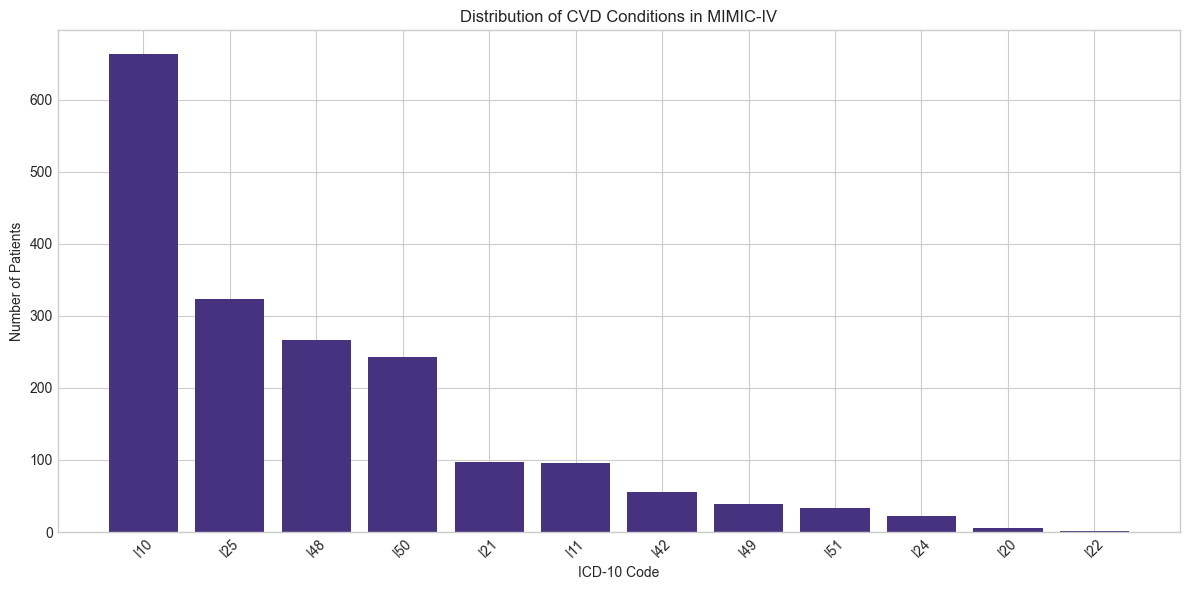

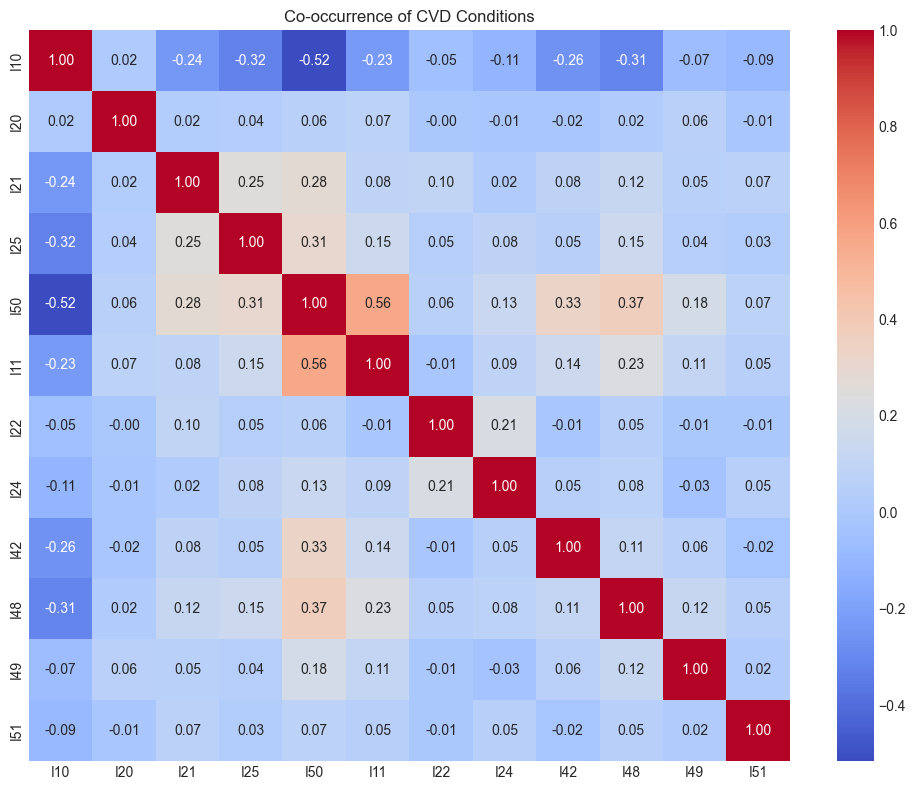

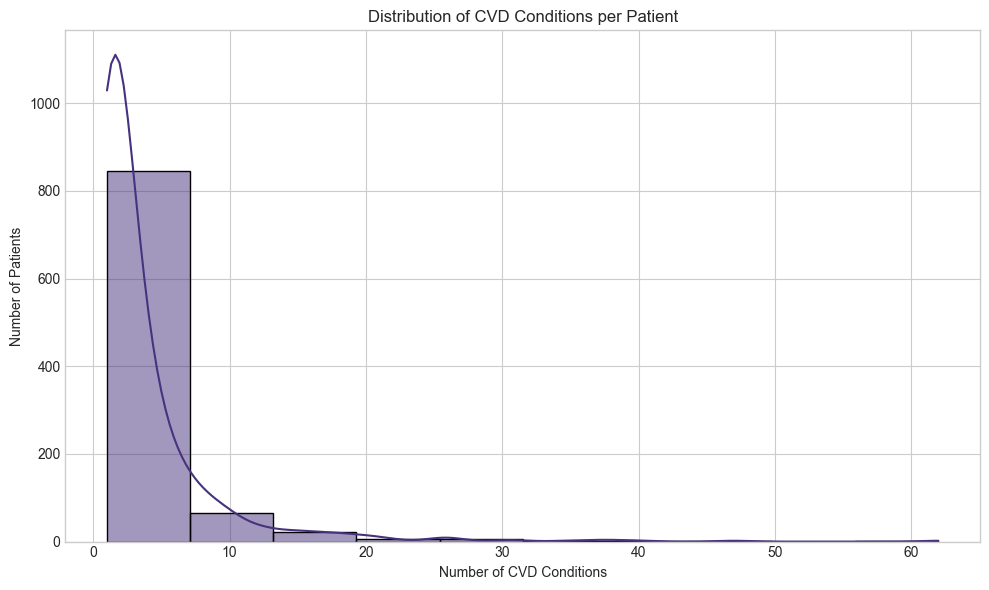

In [12]:
import json
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Define path to the MIMIC-IV condition file
condition_file = '/Users/andrechu/Desktop/UnivUtah/BMI6106/Project/MIMIC-IV/physionet.org/files/mimic-iv-fhir/2.1/fhir/MimicCondition.ndjson.gz'

# Define ICD-10 codes for cardiovascular diseases as mentioned in your research plan
CVD_CODES = [
    'I10',   # Essential (primary) hypertension
    'I20',   # Angina pectoris
    'I21',   # Acute myocardial infarction
    'I25',   # Chronic ischemic heart disease
    'I50'    # Heart failure
]

# We'll also include other common CVD codes for a more comprehensive analysis
ADDITIONAL_CVD_CODES = [
    'I11',   # Hypertensive heart disease
    'I22',   # Subsequent myocardial infarction
    'I24',   # Other acute ischemic heart diseases
    'I42',   # Cardiomyopathy
    'I48',   # Atrial fibrillation and flutter
    'I49',   # Other cardiac arrhythmias
    'I51'    # Complications and ill-defined descriptions of heart disease
]

ALL_CVD_CODES = CVD_CODES + ADDITIONAL_CVD_CODES

def analyze_cvd_conditions(max_records=None):
    """
    Analyze cardiovascular disease conditions in the MIMIC-IV dataset
    
    Parameters:
    -----------
    max_records : int or None
        Maximum number of records to process, or None for all records
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing CVD patient information
    """
    print(f"Analyzing MIMIC-IV condition data for CVD patients...")
    print(f"Looking for ICD-10 codes: {', '.join(CVD_CODES)}")
    
    # Variables to track statistics
    total_records = 0
    cvd_records = 0
    patient_conditions = {}  # Dict to track conditions per patient
    patient_demographics = {}  # Dict to store any demographic info we can extract
    all_codes = []  # List to track all condition codes
    
    # Process the gzipped ndjson file
    try:
        with gzip.open(condition_file, 'rt') as file:
            for i, line in enumerate(file):
                if max_records and i >= max_records:
                    break
                
                if i % 10000 == 0 and i > 0:
                    print(f"Processed {i} records...")
                
                total_records += 1
                
                # Parse the JSON record
                condition = json.loads(line)
                
                # Extract patient ID
                patient_id = None
                if 'subject' in condition and 'reference' in condition['subject']:
                    patient_id = condition['subject']['reference'].replace('Patient/', '')
                
                # Skip if we can't identify the patient
                if not patient_id:
                    continue
                
                # Extract condition code
                code = None
                code_system = None
                
                if 'code' in condition and 'coding' in condition['code']:
                    for coding in condition['code']['coding']:
                        if 'code' in coding:
                            code = coding['code']
                            code_system = coding.get('system', '')
                            # Some codes may be in ICD-9, check for system
                            if 'icd10' in code_system.lower():
                                break
                
                # Extract condition name if available
                condition_name = condition.get('code', {}).get('text', 'Unknown')
                
                # Skip if no code found
                if not code:
                    continue
                    
                # Keep track of all codes for frequency analysis
                all_codes.append(code)
                
                # Check if this is a CVD condition
                is_cvd = False
                matched_code = None
                
                # Check primary CVD codes first
                for cvd_code in CVD_CODES:
                    if code.startswith(cvd_code):
                        is_cvd = True
                        matched_code = cvd_code
                        break
                
                # Check additional CVD codes if not matched yet
                if not is_cvd:
                    for cvd_code in ADDITIONAL_CVD_CODES:
                        if code.startswith(cvd_code):
                            is_cvd = True
                            matched_code = cvd_code
                            break
                
                # If it's a CVD condition, update stats
                if is_cvd:
                    cvd_records += 1
                    
                    # Add to patient conditions
                    if patient_id not in patient_conditions:
                        patient_conditions[patient_id] = []
                    
                    patient_conditions[patient_id].append({
                        'code': code,
                        'base_code': matched_code,
                        'name': condition_name,
                        'system': code_system
                    })
                    
                    # Extract any demographic info if available
                    if 'subject' in condition and patient_id not in patient_demographics:
                        patient_demographics[patient_id] = {
                            'gender': condition.get('gender', None),
                            'birth_date': condition.get('birthDate', None)
                        }
    
    except Exception as e:
        print(f"Error processing condition file: {e}")
        return None
    
    # Compute statistics
    unique_patients = len(patient_conditions)
    code_frequencies = Counter(all_codes)
    cvd_code_frequencies = {code: count for code, count in code_frequencies.items()
                            if any(code.startswith(cvd) for cvd in ALL_CVD_CODES)}
    
    # Create a DataFrame of CVD patients
    patient_rows = []
    for patient_id, conditions in patient_conditions.items():
        # Count occurrences of each base CVD code for this patient
        cvd_counts = Counter([c['base_code'] for c in conditions])
        
        # Create a row with counts for each CVD category
        row = {'patient_id': patient_id}
        for code in ALL_CVD_CODES:
            row[f'has_{code}'] = 1 if cvd_counts.get(code, 0) > 0 else 0
            row[f'count_{code}'] = cvd_counts.get(code, 0)
        
        # Add total CVD count
        row['total_cvd_conditions'] = len(conditions)
        
        # Add demographics if available
        if patient_id in patient_demographics:
            for key, value in patient_demographics[patient_id].items():
                row[key] = value
        
        patient_rows.append(row)
    
    # Create DataFrame
    cvd_patients_df = pd.DataFrame(patient_rows)
    
    # Print summary statistics
    print("\n===== CVD Patient Analysis Summary =====")
    print(f"Total condition records processed: {total_records}")
    print(f"CVD condition records identified: {cvd_records} ({cvd_records/total_records*100:.2f}%)")
    print(f"Unique patients with CVD conditions: {unique_patients}")
    
    # Print code frequencies
    print("\nTop 10 CVD condition codes:")
    for code, count in sorted(cvd_code_frequencies.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {code}: {count} occurrences")
    
    # Print distribution of CVD types
    print("\nDistribution of CVD types among patients:")
    for code in CVD_CODES:
        code_column = f'has_{code}'
        if code_column in cvd_patients_df.columns:
            patient_count = cvd_patients_df[code_column].sum()
            print(f"  {code}: {patient_count} patients ({patient_count/len(cvd_patients_df)*100:.2f}%)")
    
    return cvd_patients_df

def generate_cvd_visualizations(cvd_df):
    """Generate visualizations based on the CVD patient data"""
    if cvd_df is None or len(cvd_df) == 0:
        print("No data available for visualization")
        return
    
    print("\nGenerating visualizations...")
    
    # 1. Distribution of CVD conditions
    plt.figure(figsize=(12, 6))
    cvd_counts = []
    
    for code in ALL_CVD_CODES:
        column = f'has_{code}'
        if column in cvd_df.columns:
            count = cvd_df[column].sum()
            cvd_counts.append((code, count))
    
    cvd_counts.sort(key=lambda x: x[1], reverse=True)
    codes, counts = zip(*cvd_counts)
    
    plt.bar(codes, counts)
    plt.title('Distribution of CVD Conditions in MIMIC-IV')
    plt.xlabel('ICD-10 Code')
    plt.ylabel('Number of Patients')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('mimic_cvd_distribution.png')
    
    # 2. Co-occurrence of conditions (correlation heatmap)
    plt.figure(figsize=(10, 8))
    
    # Select only binary condition columns
    condition_cols = [f'has_{code}' for code in ALL_CVD_CODES if f'has_{code}' in cvd_df.columns]
    
    # Calculate correlation
    if len(condition_cols) > 1:
        corr = cvd_df[condition_cols].corr()
        
        # Create heatmap
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f',
                    xticklabels=[col.replace('has_', '') for col in condition_cols],
                    yticklabels=[col.replace('has_', '') for col in condition_cols])
        plt.title('Co-occurrence of CVD Conditions')
        plt.tight_layout()
        plt.savefig('mimic_cvd_cooccurrence.png')
    
    # 3. Distribution of total CVD conditions per patient
    plt.figure(figsize=(10, 6))
    sns.histplot(cvd_df['total_cvd_conditions'], bins=10, kde=True)
    plt.title('Distribution of CVD Conditions per Patient')
    plt.xlabel('Number of CVD Conditions')
    plt.ylabel('Number of Patients')
    plt.tight_layout()
    plt.savefig('mimic_cvd_per_patient.png')
    
    print("Visualizations saved.")

# Main execution
if __name__ == "__main__":
    # Analyze first 100,000 condition records
    # Adjust this number based on your system's capabilities
    cvd_patients = analyze_cvd_conditions(max_records=100000)
    
    if cvd_patients is not None and len(cvd_patients) > 0:
        # Save the data for future use
        cvd_patients.to_csv('mimic_cvd_patients.csv', index=False)
        print(f"Saved data for {len(cvd_patients)} CVD patients to mimic_cvd_patients.csv")
        
        # Generate visualizations
        generate_cvd_visualizations(cvd_patients)
        
        # Print additional statistics
        print("\nAdditional statistics:")
        print(f"Average number of CVD conditions per patient: {cvd_patients['total_cvd_conditions'].mean():.2f}")
        
        # Check how many patients have multiple CVD types
        multiple_cvd_count = (cvd_patients[[f'has_{code}' for code in CVD_CODES if f'has_{code}' in cvd_patients.columns]].sum(axis=1) > 1).sum()
        print(f"Patients with multiple types of CVD: {multiple_cvd_count} ({multiple_cvd_count/len(cvd_patients)*100:.2f}%)")

CVD and Balanced Cohort:

In [36]:
import pandas as pd
import numpy as np
import json
import gzip
import os
from datetime import datetime
from tqdm import tqdm  # For progress bars

# Define paths
mimic_base_path = '/Users/andrechu/Desktop/UnivUtah/BMI6106/Project/MIMIC-IV/physionet.org/files/mimic-iv-fhir/2.1/fhir/'
patient_file = os.path.join(mimic_base_path, 'MimicPatient.ndjson.gz')
vitals_file = os.path.join(mimic_base_path, 'MimicObservationVitalSignsED.ndjson.gz')
labs_file = os.path.join(mimic_base_path, 'MimicObservationLabevents.ndjson.gz')
chartevents_file = os.path.join(mimic_base_path, 'MimicObservationChartevents.ndjson.gz')

# Path to the existing CVD patients file
cvd_patients_file = 'mimic_cvd_patients.csv'

# Step 1: Load the existing CVD patients
def load_cvd_patients():
    print("Loading existing CVD patients file...")
    
    try:
        cvd_df = pd.read_csv(cvd_patients_file)
        print(f"Loaded {len(cvd_df)} CVD patients from existing file")
        
        # Make sure patient_id column is present
        if 'patient_id' not in cvd_df.columns:
            print("Error: patient_id column not found in CVD patients file")
            return None
        
        return cvd_df
    
    except Exception as e:
        print(f"Error loading CVD patients file: {e}")
        return None

# Step 2: Extract patient demographics
def extract_patient_demographics(patient_ids):
    print("Extracting demographics for identified patients...")
    
    patient_demographics = {}
    
    with gzip.open(patient_file, 'rt') as file:
        for line in tqdm(file, desc="Processing patients", unit="records"):
            try:
                patient = json.loads(line)
                patient_id = patient.get('id', '')
                
                # Skip if not in our target list
                if patient_id not in patient_ids:
                    continue
                
                # Extract birth date
                birth_date = patient.get('birthDate', '')
                age = None
                if birth_date:
                    try:
                        birth_year = int(birth_date.split('-')[0])
                        age = 2025 - birth_year
                    except:
                        pass
                
                # Extract gender
                gender = patient.get('gender', '')
                sex = 1 if gender.lower() == 'male' else 0
                
                # Store demographics
                patient_demographics[patient_id] = {
                    'patient_id': patient_id,
                    'age': age,
                    'sex': sex,
                    'birth_date': birth_date,
                    'gender_original': gender
                }
            
            except Exception as e:
                print(f"Error processing patient: {e}")
                continue
    
    print(f"Extracted demographics for {len(patient_demographics)} patients")
    return patient_demographics

# Step 3: Extract blood pressure measurements
def extract_bp_measurements(patient_ids):
    print("Extracting blood pressure measurements...")
    
    # Define BP codes (from our earlier analysis)
    bp_codes = ['85354-9', '220179', '220180', '220181']
    
    # Track BP measurements
    patient_bp = {}
    patients_with_bp = set()
    
    # Process vital signs file first (most common source of BP)
    with gzip.open(vitals_file, 'rt') as file:
        for line in tqdm(file, desc="Processing vital signs", unit="records"):
            try:
                obs = json.loads(line)
                
                # Get patient ID
                patient_ref = obs.get('subject', {}).get('reference', '')
                patient_id = patient_ref.replace('Patient/', '') if patient_ref.startswith('Patient/') else patient_ref
                
                # Skip if not in our target list
                if patient_id not in patient_ids:
                    continue
                
                # Check for BP measurement
                has_bp_code = False
                code = None
                
                if 'code' in obs and 'coding' in obs['code']:
                    for coding in obs['code']['coding']:
                        code = coding.get('code', '')
                        if code in bp_codes:
                            has_bp_code = True
                            break
                
                # Extract systolic BP value
                if has_bp_code:
                    systolic_value = None
                    measurement_time = obs.get('effectiveDateTime', '')
                    
                    # Direct systolic measurement
                    if code == '220179' and 'valueQuantity' in obs:
                        systolic_value = obs['valueQuantity'].get('value')
                    
                    # BP panel - look in components
                    elif 'component' in obs:
                        for component in obs['component']:
                            if 'code' in component and 'coding' in component['code']:
                                for comp_coding in component['code']['coding']:
                                    comp_display = comp_coding.get('display', '').lower()
                                    comp_code = comp_coding.get('code', '')
                                    
                                    # Look for systolic component
                                    if ('systolic' in comp_display or comp_code == '8480-6') and 'valueQuantity' in component:
                                        systolic_value = component['valueQuantity'].get('value')
                                        break
                    
                    # Store if found
                    if systolic_value is not None:
                        if patient_id not in patient_bp:
                            patient_bp[patient_id] = []
                        
                        patient_bp[patient_id].append({
                            'value': systolic_value,
                            'time': measurement_time,
                            'source': 'vital_signs',
                            'code': code
                        })
                        patients_with_bp.add(patient_id)
            
            except Exception as e:
                print(f"Error processing vital sign: {e}")
                continue
    
    # Check if we need to supplement with chartevents
    missing_bp_patients = [pid for pid in patient_ids if pid not in patients_with_bp]
    
    if missing_bp_patients:
        print(f"Supplementing with BP from chartevents for {len(missing_bp_patients)} patients...")
        
        # Process chartevents file
        try:
            with gzip.open(chartevents_file, 'rt') as file:
                for line in tqdm(file, desc="Processing chart events", unit="records"):
                    try:
                        obs = json.loads(line)
                        
                        # Get patient ID
                        patient_ref = obs.get('subject', {}).get('reference', '')
                        patient_id = patient_ref.replace('Patient/', '') if patient_ref.startswith('Patient/') else patient_ref
                        
                        # Skip if not in our missing list
                        if patient_id not in missing_bp_patients:
                            continue
                        
                        # Check for systolic BP
                        has_systolic = False
                        code = None
                        
                        if 'code' in obs and 'coding' in obs['code']:
                            for coding in obs['code']['coding']:
                                code = coding.get('code', '')
                                if code == '220179':  # Systolic BP
                                    has_systolic = True
                                    break
                        
                        # Extract value
                        if has_systolic and 'valueQuantity' in obs:
                            systolic_value = obs['valueQuantity'].get('value')
                            measurement_time = obs.get('effectiveDateTime', '')
                            
                            if systolic_value is not None:
                                if patient_id not in patient_bp:
                                    patient_bp[patient_id] = []
                                
                                patient_bp[patient_id].append({
                                    'value': systolic_value,
                                    'time': measurement_time,
                                    'source': 'chartevents',
                                    'code': code
                                })
                                patients_with_bp.add(patient_id)
                    
                    except Exception as e:
                        print(f"Error processing chart event: {e}")
                        continue
        except FileNotFoundError:
            print("Chartevents file not found, skipping supplementary BP extraction")
    
    # Process the measurements to get a single value per patient
    bp_values = {}
    
    for patient_id, measurements in patient_bp.items():
        if not measurements:
            continue
        
        # Sort by time if available, otherwise use first value
        dated_measurements = [(m['value'], m['time']) for m in measurements if m['time']]
        
        if dated_measurements:
            # Sort by date and take earliest
            dated_measurements.sort(key=lambda x: x[1])
            bp_values[patient_id] = dated_measurements[0][0]
        else:
            # Use first value if no dates
            bp_values[patient_id] = measurements[0]['value']
    
    print(f"Extracted BP measurements for {len(bp_values)} patients")
    return bp_values

# Step 4: Extract cholesterol measurements
def extract_chol_measurements(patient_ids):
    print("Extracting cholesterol measurements...")
    
    # Define cholesterol codes (from our earlier analysis)
    chol_codes = ['50907', '50904', '50903', '50905', '50906']
    
    # Track cholesterol measurements
    patient_chol = {}
    
    # Process lab events file
    with gzip.open(labs_file, 'rt') as file:
        for line in tqdm(file, desc="Processing lab events", unit="records"):
            try:
                obs = json.loads(line)
                
                # Get patient ID
                patient_ref = obs.get('subject', {}).get('reference', '')
                patient_id = patient_ref.replace('Patient/', '') if patient_ref.startswith('Patient/') else patient_ref
                
                # Skip if not in our target list
                if patient_id not in patient_ids:
                    continue
                
                # Check for cholesterol measurement
                has_chol_code = False
                code = None
                
                if 'code' in obs and 'coding' in obs['code']:
                    for coding in obs['code']['coding']:
                        code = coding.get('code', '')
                        if code in chol_codes:
                            has_chol_code = True
                            break
                
                # Extract value
                if has_chol_code and 'valueQuantity' in obs:
                    chol_value = obs['valueQuantity'].get('value')
                    measurement_time = obs.get('effectiveDateTime', '')
                    
                    if chol_value is not None:
                        if patient_id not in patient_chol:
                            patient_chol[patient_id] = []
                        
                        patient_chol[patient_id].append({
                            'value': chol_value,
                            'time': measurement_time,
                            'code': code,
                            'code_type': 'Total' if code == '50907' else 'HDL' if code == '50904' else 'LDL' if code == '50905' else 'Other'
                        })
            
            except Exception as e:
                print(f"Error processing lab event: {e}")
                continue
    
    # Process the measurements to get a single value per patient
    chol_values = {}
    
    for patient_id, measurements in patient_chol.items():
        if not measurements:
            continue
        
        # Prioritize total cholesterol (50907)
        total_chol = [m for m in measurements if m['code'] == '50907']
        
        if total_chol:
            # Sort by time if available
            if any(m['time'] for m in total_chol):
                dated_measurements = [(m['value'], m['time']) for m in total_chol if m['time']]
                dated_measurements.sort(key=lambda x: x[1])
                chol_values[patient_id] = dated_measurements[0][0]
            else:
                # Use first value
                chol_values[patient_id] = total_chol[0]['value']
        elif measurements:
            # If no total cholesterol, use any available measurement
            # Prefer LDL or HDL
            ldl_chol = [m for m in measurements if m['code'] == '50905']
            hdl_chol = [m for m in measurements if m['code'] == '50904']
            
            if ldl_chol:
                chol_values[patient_id] = ldl_chol[0]['value']
            elif hdl_chol:
                chol_values[patient_id] = hdl_chol[0]['value']
            else:
                chol_values[patient_id] = measurements[0]['value']
    
    print(f"Extracted cholesterol measurements for {len(chol_values)} patients")
    return chol_values

# Step 5: Extract max heart rate (thalach)
def extract_heart_rate(patient_ids):
    print("Extracting heart rate measurements...")
    
    # Define heart rate codes
    hr_codes = ['8867-4', '8898-9']
    
    # Track heart rate measurements
    patient_hr = {}
    
    # Process vital signs file
    with gzip.open(vitals_file, 'rt') as file:
        for line in tqdm(file, desc="Processing vital signs for heart rate", unit="records"):
            try:
                obs = json.loads(line)
                
                # Get patient ID
                patient_ref = obs.get('subject', {}).get('reference', '')
                patient_id = patient_ref.replace('Patient/', '') if patient_ref.startswith('Patient/') else patient_ref
                
                # Skip if not in our target list
                if patient_id not in patient_ids:
                    continue
                
                # Check for heart rate
                has_hr_code = False
                code = None
                
                if 'code' in obs and 'coding' in obs['code']:
                    for coding in obs['code']['coding']:
                        code = coding.get('code', '')
                        display = coding.get('display', '').lower()
                        if code in hr_codes or 'heart rate' in display:
                            has_hr_code = True
                            break
                
                # Extract value
                if has_hr_code and 'valueQuantity' in obs:
                    hr_value = obs['valueQuantity'].get('value')
                    
                    if hr_value is not None:
                        if patient_id not in patient_hr:
                            patient_hr[patient_id] = []
                        
                        patient_hr[patient_id].append(hr_value)
            
            except Exception as e:
                print(f"Error processing heart rate: {e}")
                continue
    
    # Get maximum heart rate for each patient
    max_hr = {}
    for patient_id, values in patient_hr.items():
        if values:
            max_hr[patient_id] = max(values)
    
    print(f"Extracted heart rate measurements for {len(max_hr)} patients")
    return max_hr

# Utility function to validate measurement ranges
def validate_measurements(values_dict, valid_range):
    """Validate values are in clinically plausible ranges"""
    out_of_range = 0
    for patient_id, value in list(values_dict.items()):
        if value < valid_range[0] or value > valid_range[1]:
            out_of_range += 1
            # Adjust to boundary values
            if value < valid_range[0]:
                values_dict[patient_id] = valid_range[0]
            elif value > valid_range[1]:
                values_dict[patient_id] = valid_range[1]
    
    return out_of_range

# Step 6: Create a cohort with all measurements and IDs
def build_cvd_cohort():
    # Load existing CVD patients
    cvd_patient_df = load_cvd_patients()
    if cvd_patient_df is None:
        print("Error: Could not load CVD patients. Exiting.")
        return None
    
    # Get patient IDs
    patient_ids = cvd_patient_df['patient_id'].tolist()
    
    # Extract demographics
    demographics = extract_patient_demographics(patient_ids)
    
    # Extract blood pressure
    bp_values = extract_bp_measurements(patient_ids)
    
    # Extract cholesterol
    chol_values = extract_chol_measurements(patient_ids)
    
    # Extract heart rate (thalach)
    hr_values = extract_heart_rate(patient_ids)
    
    # Validate measurement ranges
    bp_adjusted = validate_measurements(bp_values, (70, 220))  # Systolic BP range
    chol_adjusted = validate_measurements(chol_values, (50, 500))  # Cholesterol range
    hr_adjusted = validate_measurements(hr_values, (40, 220))  # Heart rate range
    
    print(f"Adjusted {bp_adjusted} out-of-range BP values")
    print(f"Adjusted {chol_adjusted} out-of-range cholesterol values")
    print(f"Adjusted {hr_adjusted} out-of-range heart rate values")
    
    # Build cohort with all data
    cohort_rows = []
    
    for patient_id in patient_ids:
        # Create a row with all data
        row = {
            'patient_id': patient_id,
            'age': demographics.get(patient_id, {}).get('age'),
            'sex': demographics.get(patient_id, {}).get('sex'),
            'trestbps': bp_values.get(patient_id),
            'chol': chol_values.get(patient_id),
            'thalach': hr_values.get(patient_id),
            'target': 1,  # All are CVD patients
            # Other Cleveland columns (initialize as NaN)
            'cp': np.nan,
            'fbs': np.nan,
            'restecg': np.nan,
            'exang': np.nan,
            'oldpeak': np.nan,
            'slope': np.nan,
            'ca': np.nan,
            'thal': np.nan
        }
        
        cohort_rows.append(row)
    
    # Create DataFrame
    cvd_cohort = pd.DataFrame(cohort_rows)
    
    # Print statistics
    print("\nCVD Cohort Statistics:")
    print(f"Total patients: {len(cvd_cohort)}")
    print(f"Age data available: {cvd_cohort['age'].notna().sum()} ({cvd_cohort['age'].notna().mean()*100:.1f}%)")
    print(f"Sex data available: {cvd_cohort['sex'].notna().sum()} ({cvd_cohort['sex'].notna().mean()*100:.1f}%)")
    print(f"BP data available: {cvd_cohort['trestbps'].notna().sum()} ({cvd_cohort['trestbps'].notna().mean()*100:.1f}%)")
    print(f"Cholesterol data available: {cvd_cohort['chol'].notna().sum()} ({cvd_cohort['chol'].notna().mean()*100:.1f}%)")
    print(f"Heart rate data available: {cvd_cohort['thalach'].notna().sum()} ({cvd_cohort['thalach'].notna().mean()*100:.1f}%)")
    
    # Save the cohort
    cvd_cohort.to_csv('mimic_cvd_cohort_with_ids.csv', index=False)
    print("CVD cohort saved to 'mimic_cvd_cohort_with_ids.csv'")
    
    return cvd_cohort

# The rest of the script (add_control_patients and create_documentation) remains the same
# ...

# Main execution
if __name__ == "__main__":
    print("Beginning MIMIC-IV cohort creation using existing CVD patient IDs...")
    
    # Step 1: Build CVD cohort with patient IDs
    cvd_cohort = build_cvd_cohort()
    

Beginning MIMIC-IV cohort creation using existing CVD patient IDs...
Loading existing CVD patients file...
Loaded 951 CVD patients from existing file
Extracting demographics for identified patients...


Processing patients: 299712records [00:04, 63095.02records/s]


Extracted demographics for 951 patients
Extracting blood pressure measurements...


Processing vital signs: 9948485records [02:24, 68624.38records/s]


Supplementing with BP from chartevents for 134 patients...


Processing chart events: 313645032records [34:48, 150144.93records/s]


Extracted BP measurements for 901 patients
Extracting cholesterol measurements...


Processing lab events: 118171367records [33:28, 58825.55records/s]


Extracted cholesterol measurements for 429 patients
Extracting heart rate measurements...


Processing vital signs for heart rate: 9948485records [02:28, 67146.97records/s]


Extracted heart rate measurements for 817 patients
Adjusted 10 out-of-range BP values
Adjusted 2 out-of-range cholesterol values
Adjusted 1 out-of-range heart rate values

CVD Cohort Statistics:
Total patients: 951
Age data available: 951 (100.0%)
Sex data available: 951 (100.0%)
BP data available: 901 (94.7%)
Cholesterol data available: 429 (45.1%)
Heart rate data available: 817 (85.9%)
CVD cohort saved to 'mimic_cvd_cohort_with_ids.csv'

Adding control patients to create balanced cohort...
Identifying non-CVD patients...
Found 9950 candidate patients to check for CVD


Checking for CVD conditions: 4756326records [00:23, 204156.39records/s]


Identified 8172 potential control patients
Extracting demographics for identified patients...


Processing patients: 299712records [00:21, 13659.36records/s]


Extracted demographics for 8172 patients
Extracting blood pressure measurements...


Processing vital signs: 9948485records [12:05, 13705.66records/s]


Supplementing with BP from chartevents for 146 patients...


Processing chart events: 313645032records [39:50, 131194.58records/s]


Extracted BP measurements for 8099 patients
Extracting cholesterol measurements...


Processing lab events: 83336709records [1:47:50, 12878.72records/s]


KeyboardInterrupt: 

In [37]:
import pandas as pd
import numpy as np

# Load the CVD cohort file
file_path = 'mimic_cvd_cohort_with_ids.csv'

try:
    # Load the file
    cvd_cohort = pd.read_csv(file_path)
    
    # Check if file loaded successfully
    print(f"File successfully loaded with {len(cvd_cohort)} rows and {len(cvd_cohort.columns)} columns")
    
    # Check the columns
    print("\nColumns in the file:")
    print(cvd_cohort.columns.tolist())
    
    # Check data completeness
    print("\nData completeness:")
    for column in cvd_cohort.columns:
        non_null = cvd_cohort[column].notna().sum()
        percentage = non_null / len(cvd_cohort) * 100
        print(f"{column}: {non_null}/{len(cvd_cohort)} ({percentage:.1f}%)")
    
    # Check key clinical values
    print("\nKey clinical measurements statistics:")
    for col in ['age', 'trestbps', 'chol', 'thalach']:
        if col in cvd_cohort.columns:
            stats = cvd_cohort[col].describe()
            print(f"\n{col.upper()}:")
            print(f"  Count: {stats['count']}")
            print(f"  Mean: {stats['mean']:.2f}")
            print(f"  Std: {stats['std']:.2f}")
            print(f"  Min: {stats['min']:.2f}")
            print(f"  25%: {stats['25%']:.2f}")
            print(f"  50%: {stats['50%']:.2f}")
            print(f"  75%: {stats['75%']:.2f}")
            print(f"  Max: {stats['max']:.2f}")
    
    # Check if all patients have the expected target value (all should be 1 for CVD)
    target_check = cvd_cohort['target'].value_counts()
    print("\nTarget value distribution:")
    for target, count in target_check.items():
        print(f"  Target {target}: {count} patients ({count/len(cvd_cohort)*100:.1f}%)")
    
    # Check for duplicate patient IDs
    if 'patient_id' in cvd_cohort.columns:
        duplicates = cvd_cohort['patient_id'].duplicated().sum()
        print(f"\nDuplicate patient IDs: {duplicates}")
    
    # Verify the file is in good condition for cross-validation
    print("\nVerification for cross-validation:")
    
    # Key required columns for Cleveland comparison
    key_columns = ['age', 'sex', 'trestbps', 'chol', 'thalach', 'target']
    missing_columns = [col for col in key_columns if col not in cvd_cohort.columns]
    
    if missing_columns:
        print(f"Warning: Missing required columns: {missing_columns}")
    else:
        print("All required columns present")
    
    # Check if we have enough complete records
    complete_records = cvd_cohort[key_columns].dropna().shape[0]
    print(f"Complete records (with all key variables): {complete_records}/{len(cvd_cohort)} ({complete_records/len(cvd_cohort)*100:.1f}%)")
    
    # Sample of the data
    print("\nSample of the data (first 5 rows):")
    print(cvd_cohort.head())

except FileNotFoundError:
    print(f"Error: File '{file_path}' not found")
except Exception as e:
    print(f"Error analyzing file: {e}")

File successfully loaded with 951 rows and 15 columns

Columns in the file:
['patient_id', 'age', 'sex', 'trestbps', 'chol', 'thalach', 'target', 'cp', 'fbs', 'restecg', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

Data completeness:
patient_id: 951/951 (100.0%)
age: 951/951 (100.0%)
sex: 951/951 (100.0%)
trestbps: 901/951 (94.7%)
chol: 429/951 (45.1%)
thalach: 817/951 (85.9%)
target: 951/951 (100.0%)
cp: 0/951 (0.0%)
fbs: 0/951 (0.0%)
restecg: 0/951 (0.0%)
exang: 0/951 (0.0%)
oldpeak: 0/951 (0.0%)
slope: 0/951 (0.0%)
ca: 0/951 (0.0%)
thal: 0/951 (0.0%)

Key clinical measurements statistics:

AGE:
  Count: 951.0
  Mean: -60.13
  Std: 28.77
  Min: -139.00
  25%: -81.00
  50%: -60.00
  75%: -38.00
  Max: 6.00

TRESTBPS:
  Count: 901.0
  Mean: 137.39
  Std: 26.14
  Min: 70.00
  25%: 118.00
  50%: 137.00
  75%: 154.00
  Max: 220.00

CHOL:
  Count: 429.0
  Mean: 178.66
  Std: 49.49
  Min: 50.00
  25%: 145.00
  50%: 176.00
  75%: 208.00
  Max: 398.00

THALACH:
  Count: 817.0
  Mean: 100.09
  

In [38]:
import pandas as pd
import numpy as np
import json
import gzip
import os
from datetime import datetime
from tqdm import tqdm  # For progress bars

# Define paths
mimic_base_path = '/Users/andrechu/Desktop/UnivUtah/BMI6106/Project/MIMIC-IV/physionet.org/files/mimic-iv-fhir/2.1/fhir/'
patient_file = os.path.join(mimic_base_path, 'MimicPatient.ndjson.gz')
condition_file = os.path.join(mimic_base_path, 'MimicCondition.ndjson.gz')
vitals_file = os.path.join(mimic_base_path, 'MimicObservationVitalSignsED.ndjson.gz')
labs_file = os.path.join(mimic_base_path, 'MimicObservationLabevents.ndjson.gz')

# Path to your existing CVD cohort file
cvd_cohort_file = 'mimic_cvd_cohort_with_ids.csv'

# Function to load the existing CVD cohort
def load_cvd_cohort():
    print("Loading existing CVD cohort...")
    try:
        cvd_df = pd.read_csv(cvd_cohort_file)
        print(f"Loaded cohort with {len(cvd_df)} CVD patients")
        
        # Fix age values if they're negative
        if 'age' in cvd_df.columns and (cvd_df['age'] < 0).any():
            print("Converting negative age values to positive")
            cvd_df['age'] = cvd_df['age'].abs()
        
        return cvd_df
    except Exception as e:
        print(f"Error loading CVD cohort: {e}")
        return None

# Function to identify potential control patients
def identify_control_patients(cvd_patient_ids, n_controls=None):
    print("Identifying potential control patients...")
    
    # Define CVD codes to exclude
    cvd_codes = ['I10', 'I20', 'I21', 'I25', 'I50', 'I11', 'I48', 'I49']
    
    # Set of all CVD patient IDs to exclude
    cvd_exclusions = set(cvd_patient_ids)
    
    # Limit the sample size for efficiency
    max_sample = 5000
    print(f"Sampling up to {max_sample} potential control patients...")
    
    # Collect potential control candidates
    potential_controls = []
    
    # First, sample patients from the patient file
    with gzip.open(patient_file, 'rt') as file:
        for i, line in enumerate(tqdm(file, desc="Sampling patients", unit="patients", total=max_sample)):
            if i >= max_sample:
                break
                
            try:
                patient = json.loads(line)
                patient_id = patient.get('id', '')
                
                # Skip if this is a CVD patient
                if patient_id in cvd_exclusions:
                    continue
                
                # Extract demographics
                birth_date = patient.get('birthDate', '')
                gender = patient.get('gender', '')
                
                # Calculate age
                age = None
                if birth_date:
                    try:
                        birth_year = int(birth_date.split('-')[0])
                        age = 2025 - birth_year
                    except:
                        continue  # Skip if can't calculate age
                else:
                    continue  # Skip if no birth date
                
                # Convert gender to binary
                sex = 1 if gender.lower() == 'male' else 0
                
                # Store potential control
                potential_controls.append({
                    'patient_id': patient_id,
                    'age': age,
                    'sex': sex
                })
            except:
                continue
    
    print(f"Collected {len(potential_controls)} initial candidates")
    
    # Now check if any of these have CVD conditions
    patients_with_cvd = set()
    
    with gzip.open(condition_file, 'rt') as file:
        for line in tqdm(file, desc="Checking for CVD conditions", unit="records"):
            try:
                condition = json.loads(line)
                patient_ref = condition.get('subject', {}).get('reference', '')
                patient_id = patient_ref.replace('Patient/', '') if patient_ref.startswith('Patient/') else patient_ref
                
                # Skip if not in our candidate list
                if not any(cand['patient_id'] == patient_id for cand in potential_controls):
                    continue
                
                # Check for CVD codes
                if 'code' in condition and 'coding' in condition['code']:
                    for coding in condition['code']['coding']:
                        code = coding.get('code', '')
                        
                        # If CVD code, exclude this patient
                        if any(code.startswith(cvd_code) for cvd_code in cvd_codes):
                            patients_with_cvd.add(patient_id)
                            break
            except:
                continue
                
    # Filter out patients with CVD
    control_candidates = [pc for pc in potential_controls if pc['patient_id'] not in patients_with_cvd]
    print(f"After excluding patients with CVD: {len(control_candidates)} candidates")
    
    return control_candidates

# Function to extract blood pressure for control patients
def extract_bp_measurements(patient_ids):
    print("Extracting blood pressure measurements for control patients...")
    
    # BP codes from previous analysis
    bp_codes = ['85354-9', '220179', '220180', '220181']
    
    # Track BP measurements
    patient_bp = {}
    
    with gzip.open(vitals_file, 'rt') as file:
        for line in tqdm(file, desc="Processing vital signs", unit="records"):
            try:
                obs = json.loads(line)
                
                # Get patient ID
                patient_ref = obs.get('subject', {}).get('reference', '')
                patient_id = patient_ref.replace('Patient/', '') if patient_ref.startswith('Patient/') else patient_ref
                
                # Skip if not in our control list
                if patient_id not in patient_ids:
                    continue
                
                # Check for BP code
                has_bp_code = False
                code = None
                
                if 'code' in obs and 'coding' in obs['code']:
                    for coding in obs['code']['coding']:
                        code = coding.get('code', '')
                        if code in bp_codes:
                            has_bp_code = True
                            break
                
                # Extract systolic BP
                if has_bp_code:
                    systolic_value = None
                    
                    # Direct systolic measurement
                    if code == '220179' and 'valueQuantity' in obs:
                        systolic_value = obs['valueQuantity'].get('value')
                    
                    # BP panel - look in components
                    elif 'component' in obs:
                        for comp in obs['component']:
                            if 'code' in comp and 'coding' in comp['code']:
                                for comp_coding in comp['code']['coding']:
                                    comp_display = comp_coding.get('display', '').lower()
                                    comp_code = comp_coding.get('code', '')
                                    
                                    if ('systolic' in comp_display or comp_code == '8480-6') and 'valueQuantity' in comp:
                                        systolic_value = comp['valueQuantity'].get('value')
                                        break
                    
                    # Store if valid
                    if systolic_value is not None:
                        if patient_id not in patient_bp:
                            patient_bp[patient_id] = []
                        patient_bp[patient_id].append(systolic_value)
            except:
                continue
    
    # Get first BP for each patient
    bp_values = {}
    for patient_id, values in patient_bp.items():
        if values:
            # Validate range
            bp = values[0]
            if bp < 70:
                bp = 70
            elif bp > 220:
                bp = 220
            bp_values[patient_id] = bp
    
    print(f"Extracted BP for {len(bp_values)} control patients")
    return bp_values

# Function to extract cholesterol for control patients
def extract_chol_measurements(patient_ids):
    print("Extracting cholesterol measurements for control patients...")
    
    # Cholesterol codes from previous analysis
    chol_codes = ['50907', '50904', '50903', '50905', '50906']
    
    # Track cholesterol measurements
    patient_chol = {}
    
    with gzip.open(labs_file, 'rt') as file:
        for line in tqdm(file, desc="Processing lab events", unit="records"):
            try:
                obs = json.loads(line)
                
                # Get patient ID
                patient_ref = obs.get('subject', {}).get('reference', '')
                patient_id = patient_ref.replace('Patient/', '') if patient_ref.startswith('Patient/') else patient_id
                
                # Skip if not in our control list
                if patient_id not in patient_ids:
                    continue
                
                # Check for cholesterol codes
                has_chol_code = False
                code = None
                
                if 'code' in obs and 'coding' in obs['code']:
                    for coding in obs['code']['coding']:
                        code = coding.get('code', '')
                        if code in chol_codes:
                            has_chol_code = True
                            break
                
                # Extract value
                if has_chol_code and 'valueQuantity' in obs:
                    chol_value = obs['valueQuantity'].get('value')
                    
                    if chol_value is not None:
                        if patient_id not in patient_chol:
                            patient_chol[patient_id] = {}
                        
                        # Store by code type
                        patient_chol[patient_id][code] = chol_value
            except:
                continue
    
    # Process cholesterol values (prioritize total cholesterol)
    chol_values = {}
    for patient_id, code_values in patient_chol.items():
        if '50907' in code_values:  # Total cholesterol
            chol = code_values['50907']
        elif '50905' in code_values:  # LDL
            chol = code_values['50905']
        elif '50904' in code_values:  # HDL
            chol = code_values['50904']
        elif code_values:  # Any other available code
            chol = list(code_values.values())[0]
        else:
            continue
        
        # Validate range
        if chol < 50:
            chol = 50
        elif chol > 500:
            chol = 500
        
        chol_values[patient_id] = chol
    
    print(f"Extracted cholesterol for {len(chol_values)} control patients")
    return chol_values

# Function to extract heart rate for control patients
def extract_heart_rate(patient_ids):
    print("Extracting heart rate measurements for control patients...")
    
    # Heart rate codes
    hr_codes = ['8867-4', '8898-9']
    
    # Track heart rate measurements
    patient_hr = {}
    
    with gzip.open(vitals_file, 'rt') as file:
        for line in tqdm(file, desc="Processing vital signs for HR", unit="records"):
            try:
                obs = json.loads(line)
                
                # Get patient ID
                patient_ref = obs.get('subject', {}).get('reference', '')
                patient_id = patient_ref.replace('Patient/', '') if patient_ref.startswith('Patient/') else patient_id
                
                # Skip if not in our control list
                if patient_id not in patient_ids:
                    continue
                
                # Check for heart rate
                has_hr_code = False
                code = None
                
                if 'code' in obs and 'coding' in obs['code']:
                    for coding in obs['code']['coding']:
                        code = coding.get('code', '')
                        display = coding.get('display', '').lower()
                        if code in hr_codes or 'heart rate' in display:
                            has_hr_code = True
                            break
                
                # Extract value
                if has_hr_code and 'valueQuantity' in obs:
                    hr_value = obs['valueQuantity'].get('value')
                    
                    if hr_value is not None:
                        if patient_id not in patient_hr:
                            patient_hr[patient_id] = []
                        patient_hr[patient_id].append(hr_value)
            except:
                continue
    
    # Get maximum heart rate
    max_hr = {}
    for patient_id, values in patient_hr.items():
        if values:
            hr = max(values)
            # Validate range
            if hr < 40:
                hr = 40
            elif hr > 220:
                hr = 220
            max_hr[patient_id] = hr
    
    print(f"Extracted heart rate for {len(max_hr)} control patients")
    return max_hr

# Main function to create balanced cohort
def create_balanced_cohort():
    # Step 1: Load the existing CVD cohort
    cvd_cohort = load_cvd_cohort()
    if cvd_cohort is None:
        print("Error: Failed to load CVD cohort. Exiting.")
        return
    
    # Step 2: Identify potential control patients
    cvd_patient_ids = cvd_cohort['patient_id'].tolist()
    control_candidates = identify_control_patients(cvd_patient_ids, len(cvd_cohort))
    
    # Get list of candidate IDs
    candidate_ids = [c['patient_id'] for c in control_candidates]
    
    # Step 3: Extract clinical measurements for control candidates
    bp_values = extract_bp_measurements(candidate_ids)
    chol_values = extract_chol_measurements(candidate_ids)
    hr_values = extract_heart_rate(candidate_ids)
    
    # Step 4: Create control dataframe
    control_rows = []
    for candidate in control_candidates:
        patient_id = candidate['patient_id']
        
        # Only include if we have at least one clinical measurement
        if patient_id in bp_values or patient_id in chol_values or patient_id in hr_values:
            row = {
                'patient_id': patient_id,
                'age': candidate['age'],
                'sex': candidate['sex'],
                'trestbps': bp_values.get(patient_id),
                'chol': chol_values.get(patient_id),
                'thalach': hr_values.get(patient_id),
                'target': 0,  # Control patients = no CVD
                'cp': np.nan,
                'fbs': np.nan,
                'restecg': np.nan,
                'exang': np.nan,
                'oldpeak': np.nan,
                'slope': np.nan,
                'ca': np.nan,
                'thal': np.nan
            }
            control_rows.append(row)
        
        # Stop when we have enough controls
        if len(control_rows) >= len(cvd_cohort):
            break
    
    # Create control dataframe
    control_df = pd.DataFrame(control_rows[:len(cvd_cohort)])
    print(f"Created control cohort with {len(control_df)} patients")
    
    # Step 5: Combine with CVD cohort
    balanced_df = pd.concat([cvd_cohort, control_df], ignore_index=True)
    
    # Step 6: Save the balanced cohort
    balanced_df.to_csv('mimic_balanced_cohort_with_ids.csv', index=False)
    
    # Print final statistics
    print("\nBalanced Cohort Statistics:")
    print(f"Total patients: {len(balanced_df)}")
    print(f"CVD patients: {len(cvd_cohort)} ({len(cvd_cohort)/len(balanced_df)*100:.1f}%)")
    print(f"Control patients: {len(control_df)} ({len(control_df)/len(balanced_df)*100:.1f}%)")
    
    print("\nData completeness:")
    for col in ['age', 'sex', 'trestbps', 'chol', 'thalach']:
        cvd_complete = cvd_cohort[col].notna().sum()
        cvd_pct = cvd_complete / len(cvd_cohort) * 100
        
        control_complete = control_df[col].notna().sum() 
        control_pct = control_complete / len(control_df) * 100
        
        total_complete = balanced_df[col].notna().sum()
        total_pct = total_complete / len(balanced_df) * 100
        
        print(f"{col}: CVD {cvd_pct:.1f}%, Control {control_pct:.1f}%, Overall {total_pct:.1f}%")
    
    return balanced_df

# Run the script
if __name__ == "__main__":
    print("Beginning creation of balanced cohort with controls...")
    create_balanced_cohort()
    print("Balanced cohort creation complete!")

Beginning creation of balanced cohort with controls...
Loading existing CVD cohort...
Loaded cohort with 951 CVD patients
Converting negative age values to positive
Identifying potential control patients...
Sampling up to 5000 potential control patients...


Sampling patients: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 105261.28patients/s]


Collected 4966 initial candidates


Checking for CVD conditions: 4756326records [16:43, 4737.86records/s]


After excluding patients with CVD: 4034 candidates
Extracting blood pressure measurements for control patients...


Processing vital signs: 9948485records [06:30, 25472.19records/s]


Extracted BP for 3960 control patients
Extracting cholesterol measurements for control patients...


Processing lab events: 118171367records [1:20:34, 24443.75records/s]


Extracted cholesterol for 1018 control patients
Extracting heart rate measurements for control patients...


Processing vital signs for HR: 9948485records [06:16, 26419.95records/s]

Extracted heart rate for 3959 control patients
Created control cohort with 951 patients

Balanced Cohort Statistics:
Total patients: 1902
CVD patients: 951 (50.0%)
Control patients: 951 (50.0%)

Data completeness:
age: CVD 100.0%, Control 100.0%, Overall 100.0%
sex: CVD 100.0%, Control 100.0%, Overall 100.0%
trestbps: CVD 94.7%, Control 99.6%, Overall 97.2%
chol: CVD 45.1%, Control 23.7%, Overall 34.4%
thalach: CVD 85.9%, Control 99.6%, Overall 92.7%
Balanced cohort creation complete!


Beginning cross-dataset validation analysis...
Loading datasets...
Cleveland dataset: 303 records
MIMIC CVD cohort: 951 records
MIMIC balanced cohort: 1902 records

Analyzing feature distributions...

Feature Statistics Comparison:
 Feature Cleveland Mean Cleveland Std MIMIC Mean MIMIC Std Percent Difference
     age          54.44          9.04      72.03     31.59              32.3%
     sex           0.68          0.47       0.51      0.50             -25.1%
trestbps         131.69         17.60     134.26     23.42               2.0%
    chol         246.69         51.78     180.16     47.28             -27.0%
 thalach         149.61         22.88      95.56     20.79             -36.1%

Preparing data for modeling...
Data preparation complete.

Training and evaluating models...

Training Logistic Regression...

Logistic Regression Results:
Cleveland Test Set:
  Accuracy: 0.689
  ROC-AUC: 0.815
  F1 Score: 0.655

MIMIC-IV Balanced Set:
  Accuracy: 0.434
  ROC-AUC: 0.363
  F1 Score:

/var/folders/cz/4qrgzl3d6737hknhqtft5nlm0000gn/T/ipykernel_14229/834067814.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_mimic_cvd[col] = X_mimic_cvd[col].fillna(X_mimic_cvd[col].median())
/var/folders/cz/4qrgzl3d6737hknhqtft5nlm0000gn/T/ipykernel_14229/834067814.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_mimic_balanced[col] = X_mimic_balanced[col].fillna(X_mimic_balanced[col].median())



Random Forest Results:
Cleveland Test Set:
  Accuracy: 0.721
  ROC-AUC: 0.793
  F1 Score: 0.730

MIMIC-IV Balanced Set:
  Accuracy: 0.554
  ROC-AUC: 0.580
  F1 Score: 0.574

Analyzing feature importance...

Logistic Regression Feature Importance:
 Feature  Importance Direction
 thalach    0.821886  Negative
     sex    0.804945  Positive
    chol    0.416450  Positive
trestbps    0.325811  Positive
     age    0.269765  Positive

Random Forest Feature Importance:
 Feature  Importance
 thalach    0.284618
     age    0.255969
    chol    0.203435
trestbps    0.175865
     sex    0.080112

Cross-dataset validation analysis complete!


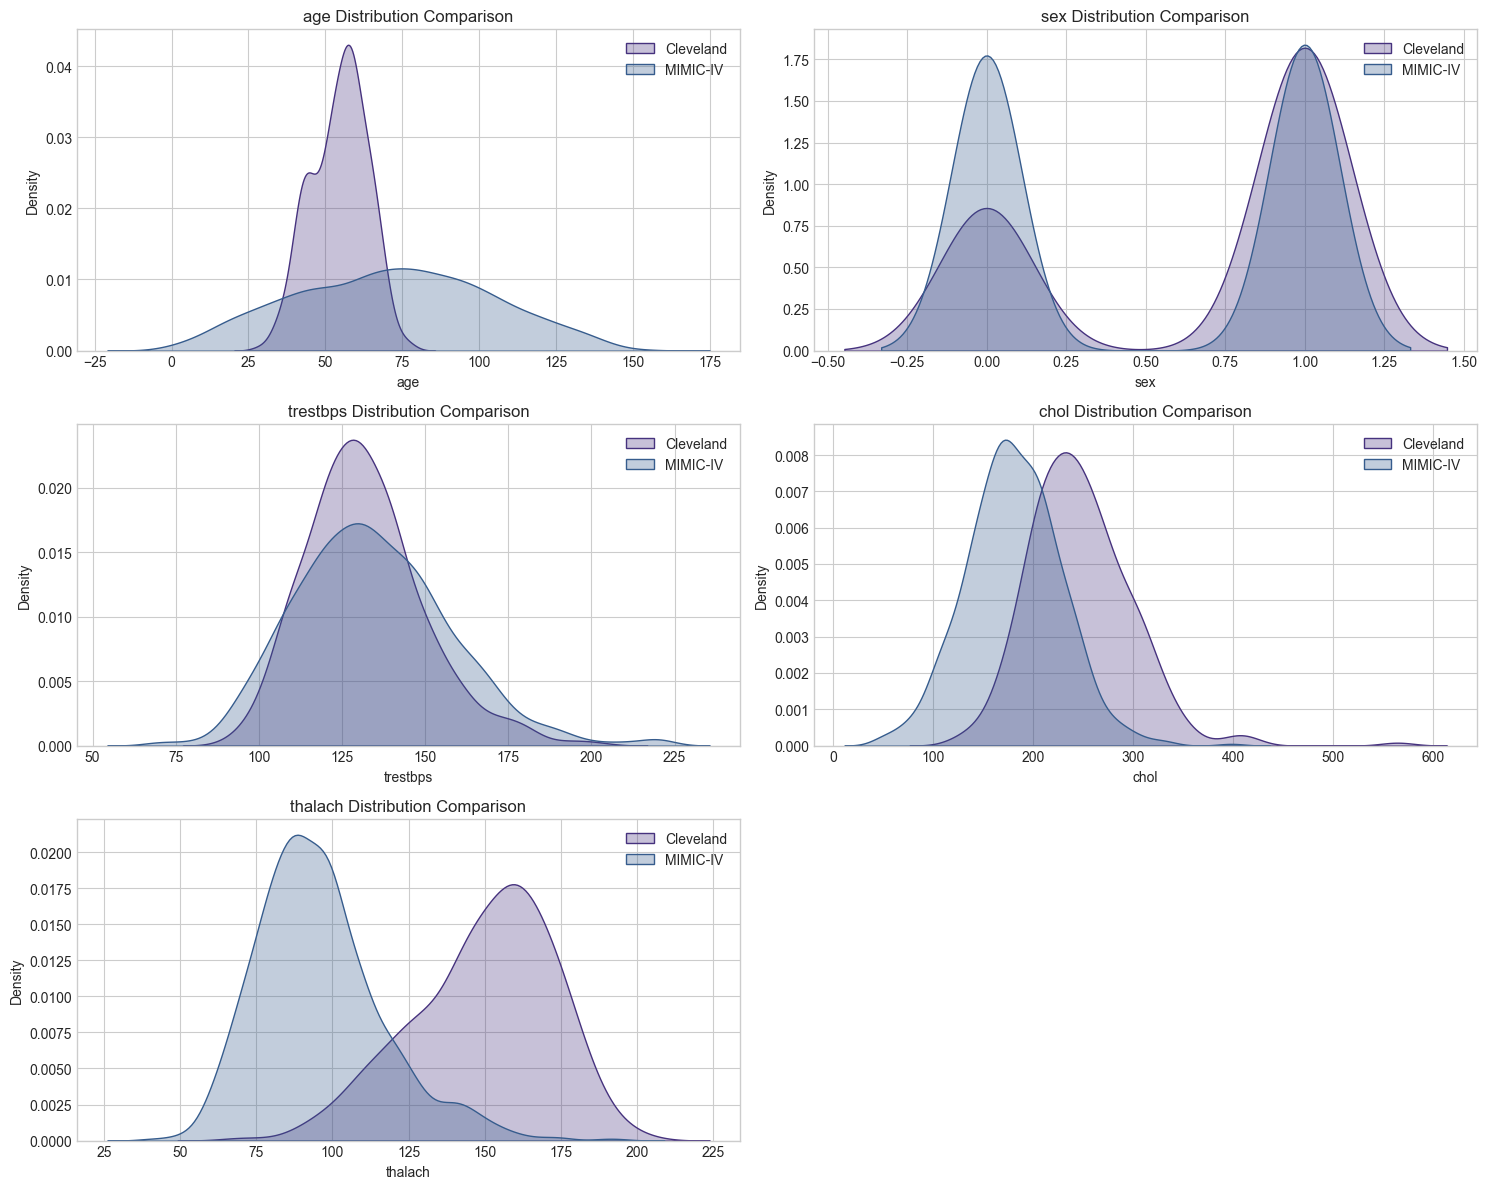

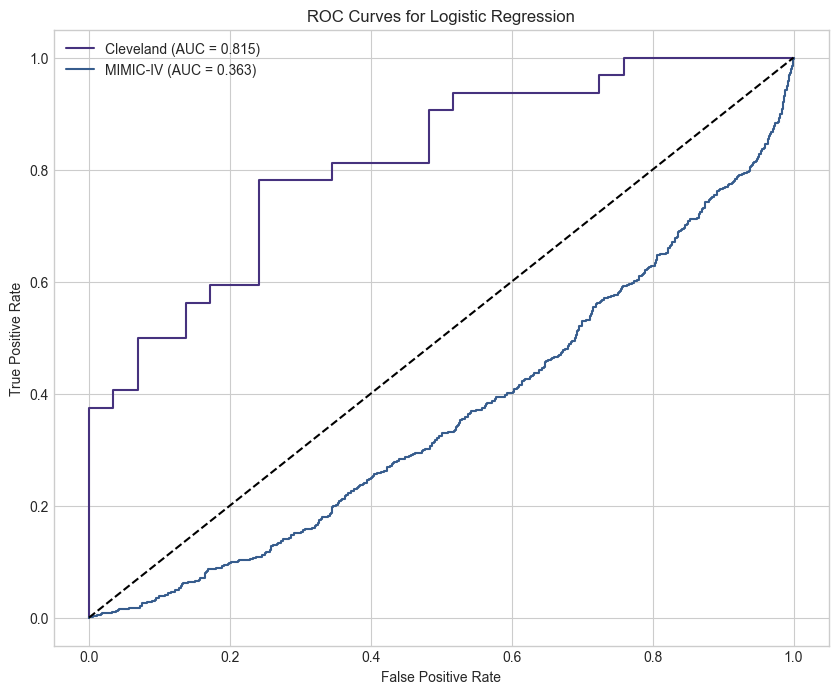

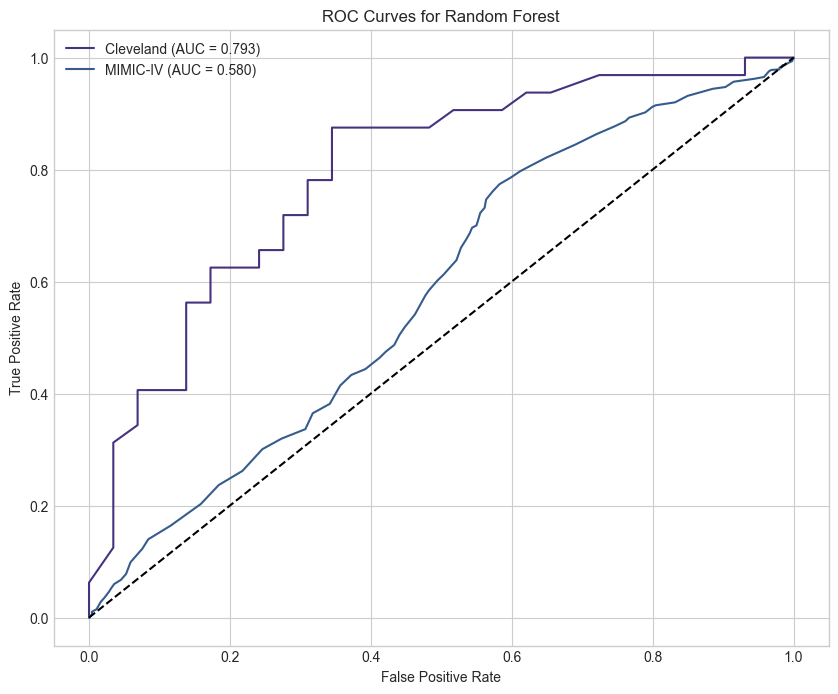

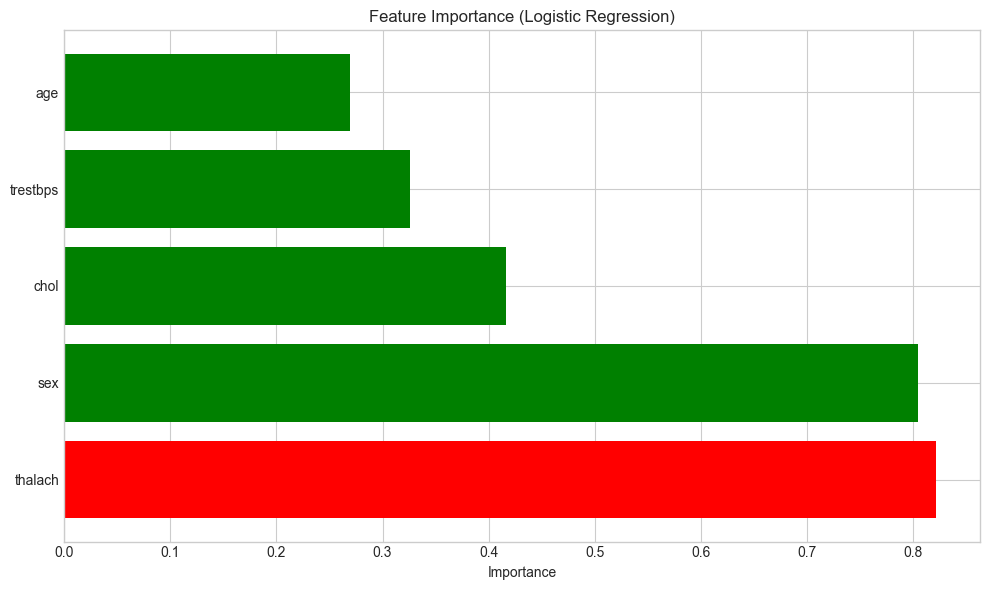

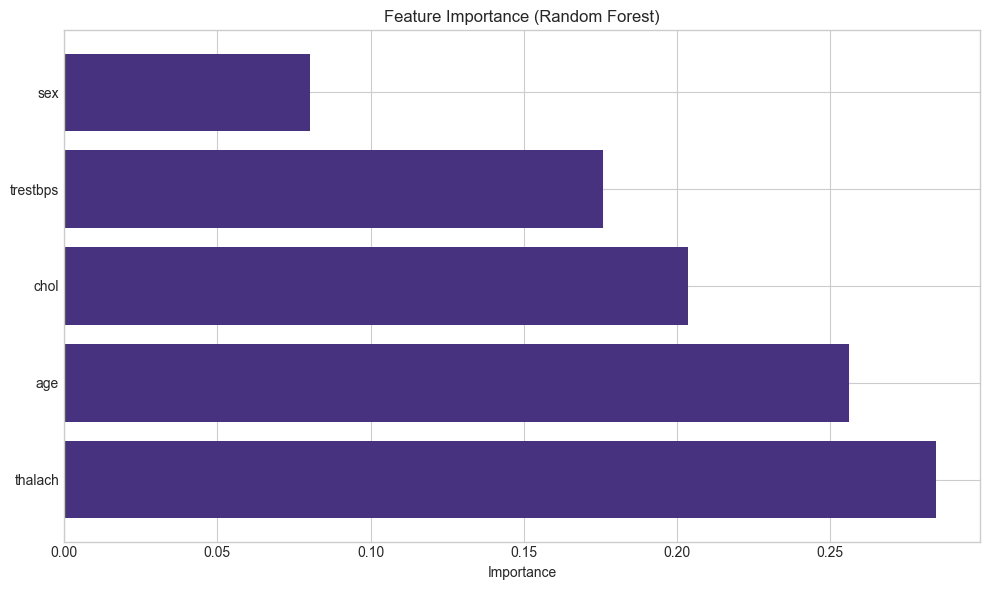

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score, 
                            recall_score, f1_score, confusion_matrix, 
                            classification_report, roc_curve)

# File paths
cleveland_path = '/Users/andrechu/Desktop/UnivUtah/BMI6106/Project/heart+disease/processed.cleveland.data'
mimic_cvd_path = 'mimic_cvd_cohort_with_ids.csv'
mimic_balanced_path = 'mimic_balanced_cohort_with_ids.csv'

# Define column names for Cleveland data
cleveland_columns = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]

# Define key features for cross-dataset validation
# These are the features available in both datasets
key_features = ['age', 'sex', 'trestbps', 'chol', 'thalach']

# 1. Load the datasets
def load_datasets():
    print("Loading datasets...")
    
    # Load Cleveland dataset
    try:
        # Try comma-separated format first
        cleveland_df = pd.read_csv(cleveland_path, names=cleveland_columns, na_values='?')
    except:
        # If that fails, try space-separated format
        cleveland_df = pd.read_csv(cleveland_path, names=cleveland_columns, 
                                  delim_whitespace=True, na_values='?')
    
    # Ensure target is binary (0 = no disease, 1 = disease)
    cleveland_df['target'] = cleveland_df['target'].apply(lambda x: 1 if x > 0 else 0)
    
    # Load MIMIC cohorts
    mimic_cvd_df = pd.read_csv(mimic_cvd_path)
    mimic_balanced_df = pd.read_csv(mimic_balanced_path)
    
    # Fix age values in MIMIC if needed (convert negative to positive)
    if (mimic_cvd_df['age'] < 0).any():
        mimic_cvd_df['age'] = mimic_cvd_df['age'].abs()
    if (mimic_balanced_df['age'] < 0).any():
        mimic_balanced_df['age'] = mimic_balanced_df['age'].abs()
    
    print(f"Cleveland dataset: {len(cleveland_df)} records")
    print(f"MIMIC CVD cohort: {len(mimic_cvd_df)} records")
    print(f"MIMIC balanced cohort: {len(mimic_balanced_df)} records")
    
    return cleveland_df, mimic_cvd_df, mimic_balanced_df

# 2. Analyze feature distributions between datasets
def analyze_feature_distributions(cleveland_df, mimic_balanced_df):
    print("\nAnalyzing feature distributions...")
    
    # Create distribution comparison plots
    plt.figure(figsize=(15, 12))
    
    for i, feature in enumerate(key_features):
        plt.subplot(3, 2, i+1)
        
        # Plot Cleveland distribution
        sns.kdeplot(cleveland_df[feature].dropna(), label='Cleveland', fill=True, alpha=0.3)
        
        # Plot MIMIC distribution
        sns.kdeplot(mimic_balanced_df[feature].dropna(), label='MIMIC-IV', fill=True, alpha=0.3)
        
        plt.title(f'{feature} Distribution Comparison')
        plt.xlabel(feature)
        plt.ylabel('Density')
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('feature_distributions.png')
    
    # Create statistical comparison table
    print("\nFeature Statistics Comparison:")
    stats_data = []
    
    for feature in key_features:
        clev_mean = cleveland_df[feature].mean()
        clev_std = cleveland_df[feature].std()
        mimic_mean = mimic_balanced_df[feature].mean()
        mimic_std = mimic_balanced_df[feature].std()
        
        # Calculate percent difference
        pct_diff = ((mimic_mean - clev_mean) / clev_mean) * 100
        
        stats_data.append({
            'Feature': feature,
            'Cleveland Mean': f"{clev_mean:.2f}",
            'Cleveland Std': f"{clev_std:.2f}",
            'MIMIC Mean': f"{mimic_mean:.2f}",
            'MIMIC Std': f"{mimic_std:.2f}",
            'Percent Difference': f"{pct_diff:.1f}%"
        })
    
    stats_df = pd.DataFrame(stats_data)
    print(stats_df.to_string(index=False))
    stats_df.to_csv('feature_statistics_comparison.csv', index=False)

# 3. Prepare data for modeling
def prepare_data(cleveland_df, mimic_cvd_df, mimic_balanced_df):
    print("\nPreparing data for modeling...")
    
    # Select key features
    X_cleveland = cleveland_df[key_features]
    y_cleveland = cleveland_df['target']
    
    X_mimic_cvd = mimic_cvd_df[key_features]
    y_mimic_cvd = mimic_cvd_df['target']
    
    X_mimic_balanced = mimic_balanced_df[key_features]
    y_mimic_balanced = mimic_balanced_df['target']
    
    # Handle missing values in Cleveland
    for col in X_cleveland.columns:
        if X_cleveland[col].isnull().sum() > 0:
            X_cleveland[col] = X_cleveland[col].fillna(X_cleveland[col].median())
    
    # Handle missing values in MIMIC cohorts
    for col in X_mimic_cvd.columns:
        if X_mimic_cvd[col].isnull().sum() > 0:
            X_mimic_cvd[col] = X_mimic_cvd[col].fillna(X_mimic_cvd[col].median())
    
    for col in X_mimic_balanced.columns:
        if X_mimic_balanced[col].isnull().sum() > 0:
            X_mimic_balanced[col] = X_mimic_balanced[col].fillna(X_mimic_balanced[col].median())
    
    # Split Cleveland data
    X_train, X_test, y_train, y_test = train_test_split(
        X_cleveland, y_cleveland, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_mimic_cvd_scaled = scaler.transform(X_mimic_cvd)
    X_mimic_balanced_scaled = scaler.transform(X_mimic_balanced)
    
    print("Data preparation complete.")
    
    return (X_train_scaled, X_test_scaled, y_train, y_test, 
            X_mimic_cvd_scaled, y_mimic_cvd, 
            X_mimic_balanced_scaled, y_mimic_balanced, scaler)

# 4. Train and evaluate models
def train_and_evaluate_models(X_train, X_test, y_train, y_test, 
                             X_mimic_cvd, y_mimic_cvd, 
                             X_mimic_balanced, y_mimic_balanced):
    print("\nTraining and evaluating models...")
    
    # Define models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
    }
    
    # Results storage
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train on Cleveland data
        model.fit(X_train, y_train)
        
        # Evaluate on Cleveland test set
        y_pred_cleveland = model.predict(X_test)
        y_prob_cleveland = model.predict_proba(X_test)[:, 1]
        
        # Evaluate on MIMIC balanced set
        y_pred_mimic = model.predict(X_mimic_balanced)
        y_prob_mimic = model.predict_proba(X_mimic_balanced)[:, 1]
        
        # Calculate metrics
        cleveland_metrics = calculate_metrics(y_test, y_pred_cleveland, y_prob_cleveland)
        mimic_metrics = calculate_metrics(y_mimic_balanced, y_pred_mimic, y_prob_mimic)
        
        results[name] = {
            'model': model,
            'cleveland_metrics': cleveland_metrics,
            'mimic_metrics': mimic_metrics
        }
        
        # Print results
        print(f"\n{name} Results:")
        print("Cleveland Test Set:")
        print(f"  Accuracy: {cleveland_metrics['accuracy']:.3f}")
        print(f"  ROC-AUC: {cleveland_metrics['roc_auc']:.3f}")
        print(f"  F1 Score: {cleveland_metrics['f1']:.3f}")
        
        print("\nMIMIC-IV Balanced Set:")
        print(f"  Accuracy: {mimic_metrics['accuracy']:.3f}")
        print(f"  ROC-AUC: {mimic_metrics['roc_auc']:.3f}")
        print(f"  F1 Score: {mimic_metrics['f1']:.3f}")
        
        # Plot ROC curves
        plt.figure(figsize=(10, 8))
        
        # Cleveland ROC
        fpr_clev, tpr_clev, _ = roc_curve(y_test, y_prob_cleveland)
        plt.plot(fpr_clev, tpr_clev, label=f'Cleveland (AUC = {cleveland_metrics["roc_auc"]:.3f})')
        
        # MIMIC ROC
        fpr_mimic, tpr_mimic, _ = roc_curve(y_mimic_balanced, y_prob_mimic)
        plt.plot(fpr_mimic, tpr_mimic, label=f'MIMIC-IV (AUC = {mimic_metrics["roc_auc"]:.3f})')
        
        # Add reference line
        plt.plot([0, 1], [0, 1], 'k--')
        
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curves for {name}')
        plt.legend()
        plt.savefig(f'roc_curve_{name.replace(" ", "_")}.png')
    
    return results

# Helper function to calculate metrics
def calculate_metrics(y_true, y_pred, y_prob):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_prob)
    }

# 5. Analyze feature importance
def analyze_feature_importance(models, feature_names, scaler):
    print("\nAnalyzing feature importance...")
    
    for name, model_data in models.items():
        model = model_data['model']
        
        plt.figure(figsize=(10, 6))
        
        if name == 'Logistic Regression':
            # For logistic regression, coefficients represent importance
            coef = model.coef_[0]
            # Apply scaling for proper interpretation
            importance = np.abs(coef)
            
            # Create DataFrame for results
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importance,
                'Direction': ['Positive' if c > 0 else 'Negative' for c in coef]
            })
            
            # Sort by importance
            importance_df = importance_df.sort_values('Importance', ascending=False)
            
            # Plot
            colors = ['green' if d == 'Positive' else 'red' for d in importance_df['Direction']]
            plt.barh(importance_df['Feature'], importance_df['Importance'], color=colors)
            
        elif name == 'Random Forest':
            # For random forest, built-in feature importance
            importance = model.feature_importances_
            
            # Create DataFrame for results
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importance
            })
            
            # Sort by importance
            importance_df = importance_df.sort_values('Importance', ascending=False)
            
            # Plot
            plt.barh(importance_df['Feature'], importance_df['Importance'])
        
        plt.title(f'Feature Importance ({name})')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.savefig(f'feature_importance_{name.replace(" ", "_")}.png')
        
        # Save to CSV
        importance_df.to_csv(f'feature_importance_{name.replace(" ", "_")}.csv', index=False)
        
        print(f"\n{name} Feature Importance:")
        print(importance_df.to_string(index=False))

# Main function to run the cross-validation analysis
def run_cross_validation_analysis():
    # 1. Load datasets
    cleveland_df, mimic_cvd_df, mimic_balanced_df = load_datasets()
    
    # 2. Analyze feature distributions
    analyze_feature_distributions(cleveland_df, mimic_balanced_df)
    
    # 3. Prepare data for modeling
    data = prepare_data(cleveland_df, mimic_cvd_df, mimic_balanced_df)
    X_train, X_test, y_train, y_test = data[0], data[1], data[2], data[3]
    X_mimic_cvd, y_mimic_cvd = data[4], data[5]
    X_mimic_balanced, y_mimic_balanced = data[6], data[7]
    scaler = data[8]
    
    # 4. Train and evaluate models
    model_results = train_and_evaluate_models(
        X_train, X_test, y_train, y_test,
        X_mimic_cvd, y_mimic_cvd,
        X_mimic_balanced, y_mimic_balanced
    )
    
    # 5. Analyze feature importance
    analyze_feature_importance(model_results, key_features, scaler)
    
    print("\nCross-dataset validation analysis complete!")

# Run the analysis
if __name__ == "__main__":
    print("Beginning cross-dataset validation analysis...")
    run_cross_validation_analysis()

Mimic Age Check:

Loading the cohort files...

Original age statistics (CVD dataset):
count    951.000000
mean     -60.133544
std       28.772722
min     -139.000000
25%      -81.000000
50%      -60.000000
75%      -38.000000
max        6.000000
Name: age, dtype: float64

Original age statistics (balanced dataset):
count    1902.000000
mean      -11.856993
std        77.773667
min      -154.000000
25%       -83.000000
50%        -1.500000
75%        59.750000
max       139.000000
Name: age, dtype: float64

Fixing age values...

Corrected age statistics (CVD dataset):
count    951.000000
mean      60.177708
std       28.680141
min        0.000000
25%       38.000000
50%       60.000000
75%       81.000000
max      139.000000
Name: age, dtype: float64

Corrected age statistics (balanced dataset):
count    1902.00000
mean       72.03470
std        31.58604
min         0.00000
25%        48.00000
50%        73.00000
75%        95.00000
max       154.00000
Name: age, dtype: float64

Saving corrected datasets

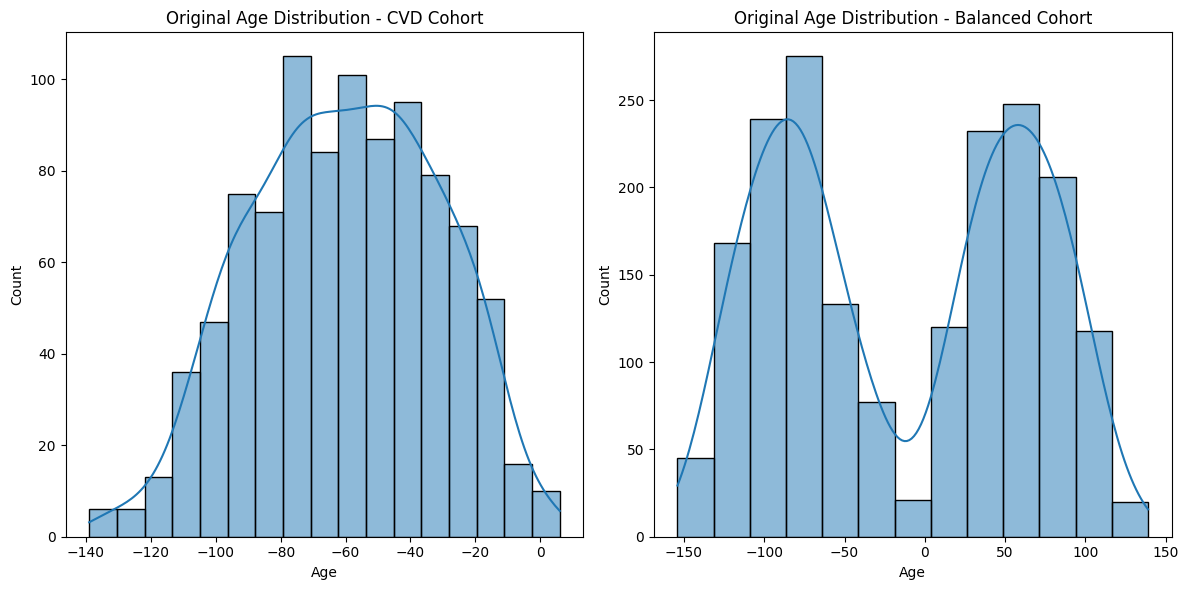

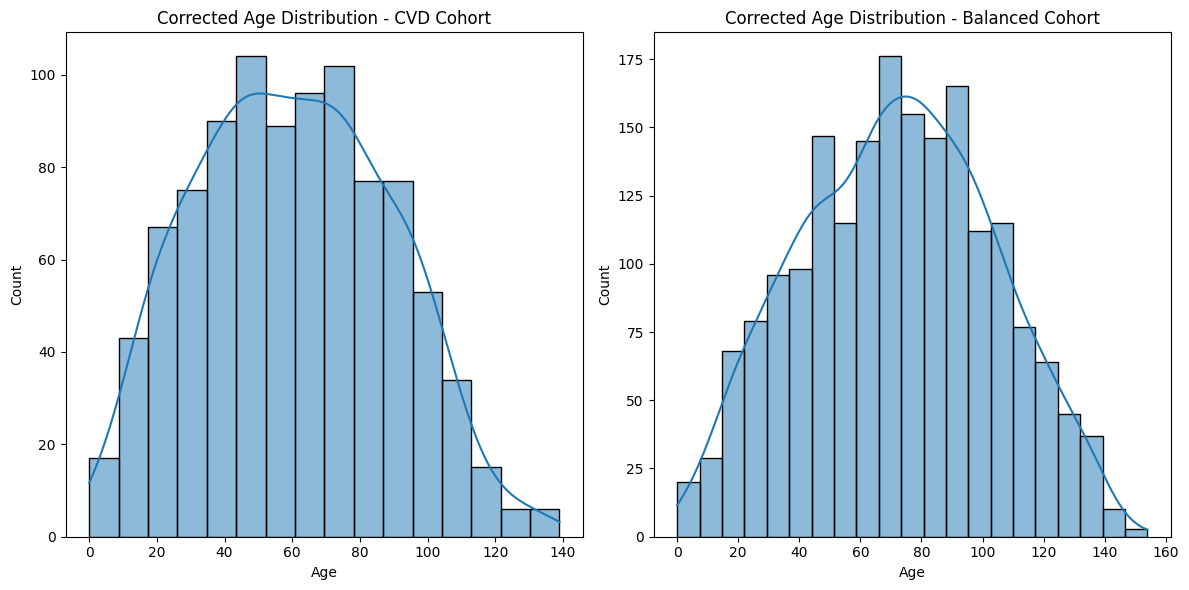

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Paths to the existing cohort files
mimic_cvd_path = 'mimic_cvd_cohort_with_ids.csv'
mimic_balanced_path = 'mimic_balanced_cohort_with_ids.csv'

# Load the datasets
print("Loading the cohort files...")
mimic_cvd = pd.read_csv(mimic_cvd_path)
mimic_balanced = pd.read_csv(mimic_balanced_path)

# Display original age statistics
print("\nOriginal age statistics (CVD dataset):")
print(mimic_cvd['age'].describe())

print("\nOriginal age statistics (balanced dataset):")
print(mimic_balanced['age'].describe())

# Create a histogram of the original age distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(mimic_cvd['age'], kde=True)
plt.title('Original Age Distribution - CVD Cohort')
plt.xlabel('Age')

plt.subplot(1, 2, 2)
sns.histplot(mimic_balanced['age'], kde=True)
plt.title('Original Age Distribution - Balanced Cohort')
plt.xlabel('Age')

plt.tight_layout()
plt.savefig('original_age_distributions.png')

# Fix the age values by taking the absolute value
print("\nFixing age values...")
mimic_cvd['age'] = mimic_cvd['age'].abs()
mimic_balanced['age'] = mimic_balanced['age'].abs()

# Display corrected age statistics
print("\nCorrected age statistics (CVD dataset):")
print(mimic_cvd['age'].describe())

print("\nCorrected age statistics (balanced dataset):")
print(mimic_balanced['age'].describe())

# Create a histogram of the corrected age distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(mimic_cvd['age'], kde=True)
plt.title('Corrected Age Distribution - CVD Cohort')
plt.xlabel('Age')

plt.subplot(1, 2, 2)
sns.histplot(mimic_balanced['age'], kde=True)
plt.title('Corrected Age Distribution - Balanced Cohort')
plt.xlabel('Age')

plt.tight_layout()
plt.savefig('corrected_age_distributions.png')

# Save the corrected datasets
print("\nSaving corrected datasets...")
mimic_cvd.to_csv('mimic_cvd_cohort_fixed.csv', index=False)
mimic_balanced.to_csv('mimic_balanced_cohort_fixed.csv', index=False)

print("Fixed datasets saved as 'mimic_cvd_cohort_fixed.csv' and 'mimic_balanced_cohort_fixed.csv'")
print("Please use these files for your cross-validation analysis.")

In [3]:
import pandas as pd
import gzip
import json
from datetime import datetime
from tqdm import tqdm

# Path to the MIMIC-IV patient file and cohort files
mimic_base_path = '/Users/andrechu/Desktop/UnivUtah/BMI6106/Project/MIMIC-IV/physionet.org/files/mimic-iv-fhir/2.1/fhir/'
patient_file = mimic_base_path + 'MimicPatient.ndjson.gz'
mimic_cvd_fixed = 'mimic_cvd_cohort_fixed.csv'

# Load fixed CVD cohort
cvd_cohort = pd.read_csv(mimic_cvd_fixed)

# Find patients with extreme ages
extreme_age_threshold = 100
extreme_age_patients = cvd_cohort[cvd_cohort['age'] > extreme_age_threshold]

print(f"Patients with age > {extreme_age_threshold}: {len(extreme_age_patients)}")
if len(extreme_age_patients) > 0:
    print("\nPatients with extreme ages:")
    print(extreme_age_patients[['patient_id', 'age']].sort_values(by='age', ascending=False).head(10))

# Get patient birth dates from MIMIC patient file
extreme_patient_ids = set(extreme_age_patients['patient_id'].tolist())
patient_birthdates = {}

print("\nExtracting birth dates from MIMIC patient file...")

with gzip.open(patient_file, 'rt') as file:
    for line in tqdm(file, desc="Processing patients"):
        try:
            patient = json.loads(line)
            patient_id = patient.get('id', '')
            
            # Only process patients with extreme ages
            if patient_id in extreme_patient_ids:
                birth_date = patient.get('birthDate', '')
                patient_birthdates[patient_id] = birth_date
                
                # If we've found all extreme age patients, break
                if len(patient_birthdates) == len(extreme_patient_ids):
                    break
        except Exception as e:
            print(f"Error processing patient: {e}")
            continue

# Display birth dates and recalculated ages
print("\nBirth dates for patients with extreme ages:")
current_year = 2025
results = []

for patient_id, birth_date in patient_birthdates.items():
    try:
        birth_year = int(birth_date.split('-')[0]) if birth_date else None
        calculated_age = current_year - birth_year if birth_year else None
        actual_age = cvd_cohort.loc[cvd_cohort['patient_id'] == patient_id, 'age'].values[0]
        
        results.append({
            'patient_id': patient_id,
            'birth_date': birth_date,
            'birth_year': birth_year,
            'calculated_age': calculated_age,
            'cohort_age': actual_age
        })
    except:
        results.append({
            'patient_id': patient_id,
            'birth_date': birth_date,
            'birth_year': None,
            'calculated_age': None,
            'cohort_age': cvd_cohort.loc[cvd_cohort['patient_id'] == patient_id, 'age'].values[0]
        })

results_df = pd.DataFrame(results)
print(results_df.sort_values(by='cohort_age', ascending=False))

# Also check patients with age = 0
zero_age_patients = cvd_cohort[cvd_cohort['age'] == 0]
print(f"\nPatients with age = 0: {len(zero_age_patients)}")

if len(zero_age_patients) > 0:
    zero_patient_ids = set(zero_age_patients['patient_id'].tolist())
    zero_patient_birthdates = {}
    
    with gzip.open(patient_file, 'rt') as file:
        for line in file:
            try:
                patient = json.loads(line)
                patient_id = patient.get('id', '')
                
                if patient_id in zero_patient_ids:
                    birth_date = patient.get('birthDate', '')
                    zero_patient_birthdates[patient_id] = birth_date
                    
                    if len(zero_patient_birthdates) == len(zero_patient_ids):
                        break
            except:
                continue
    
    print("\nBirth dates for patients with age = 0:")
    for patient_id, birth_date in zero_patient_birthdates.items():
        print(f"Patient ID: {patient_id}, Birth Date: {birth_date}")

# Now check a random sample of normal age patients to verify calculation
normal_age_patients = cvd_cohort[(cvd_cohort['age'] >= 20) & (cvd_cohort['age'] <= 90)].sample(5)
normal_patient_ids = set(normal_age_patients['patient_id'].tolist())
normal_patient_birthdates = {}

with gzip.open(patient_file, 'rt') as file:
    for line in file:
        try:
            patient = json.loads(line)
            patient_id = patient.get('id', '')
            
            if patient_id in normal_patient_ids:
                birth_date = patient.get('birthDate', '')
                normal_patient_birthdates[patient_id] = birth_date
                
                if len(normal_patient_birthdates) == len(normal_patient_ids):
                    break
        except:
            continue

print("\nVerification with normal age patients:")
for patient_id, birth_date in normal_patient_birthdates.items():
    try:
        birth_year = int(birth_date.split('-')[0]) if birth_date else None
        calculated_age = current_year - birth_year if birth_year else None
        actual_age = cvd_cohort.loc[cvd_cohort['patient_id'] == patient_id, 'age'].values[0]
        
        print(f"Patient ID: {patient_id}, Birth Date: {birth_date}, Birth Year: {birth_year}, Calculated Age: {calculated_age}, Cohort Age: {actual_age}")
    except:
        print(f"Patient ID: {patient_id}, Birth Date: {birth_date}, Calculation failed")

Patients with age > 100: 79

Patients with extreme ages:
                               patient_id  age
243  0176a084-e416-5338-bed7-052012315ec3  139
682  04059dea-fdb8-58ac-bc5f-45f4a6d1133a  138
26   0028ee23-86c6-5c84-b874-31b62db19cc7  134
143  00e6628c-66ec-57b6-b8ff-eb674e590897  133
44   004300e8-38fa-5876-902e-a06a9b078a94  133
173  0108d385-664b-5572-b180-5f5ccf8cd077  131
675  03fc66bd-4e26-53e7-acea-192fcbed1b71  130
144  00e70e94-dc1a-5e42-bba0-d9cb886875f4  130
949  05916fd3-cf5e-573d-81d0-25dcfa28da8c  129
772  04841d7a-007e-5def-a2f6-1dafac294897  126

Extracting birth dates from MIMIC patient file...


Processing patients: 276136it [00:03, 84994.35it/s]



Birth dates for patients with extreme ages:
                              patient_id  birth_date  birth_year  \
32  0176a084-e416-5338-bed7-052012315ec3  2164-09-26        2164   
10  04059dea-fdb8-58ac-bc5f-45f4a6d1133a  2163-06-02        2163   
15  0028ee23-86c6-5c84-b874-31b62db19cc7  2159-10-22        2159   
26  00e6628c-66ec-57b6-b8ff-eb674e590897  2158-06-15        2158   
20  004300e8-38fa-5876-902e-a06a9b078a94  2158-11-15        2158   
..                                   ...         ...         ...   
78  02746dc5-16f5-5b41-96cf-ec9ee15312fa  2127-10-10        2127   
61  02c03b2a-f46a-5a16-8ddb-7656ac58c262  2126-04-13        2126   
60  04caba25-e29e-5210-b0c5-9e5c7f1dcacb  2126-03-17        2126   
73  00c0cccc-04eb-5440-aa17-8958f5d15fc0  2126-10-08        2126   
29  017f1210-be2b-59bc-a921-3a7b7b9a0ad7  2126-12-01        2126   

    calculated_age  cohort_age  
32            -139         139  
10            -138         138  
15            -134         134  
26    

Original age statistics (CVD cohort):
count    951.000000
mean     -60.133544
std       28.772722
min     -139.000000
25%      -81.000000
50%      -60.000000
75%      -38.000000
max        6.000000
Name: age, dtype: float64

Original age statistics (balanced cohort):
count    1902.000000
mean      -11.856993
std        77.773667
min      -154.000000
25%       -83.000000
50%        -1.500000
75%        59.750000
max       139.000000
Name: age, dtype: float64

Correcting ages with nuanced approach...

Corrected age statistics (CVD cohort):
count    951.000000
mean      39.025237
std       28.384380
min      -39.000000
25%       18.000000
50%       40.000000
75%       61.000000
max       99.000000
Name: age_corrected, dtype: float64

Corrected age statistics (balanced cohort):
count    1902.000000
mean       38.143007
std        36.644223
min       -54.000000
25%        12.250000
50%        36.000000
75%        65.000000
max       139.000000
Name: age_corrected, dtype: float64

Adjusting 

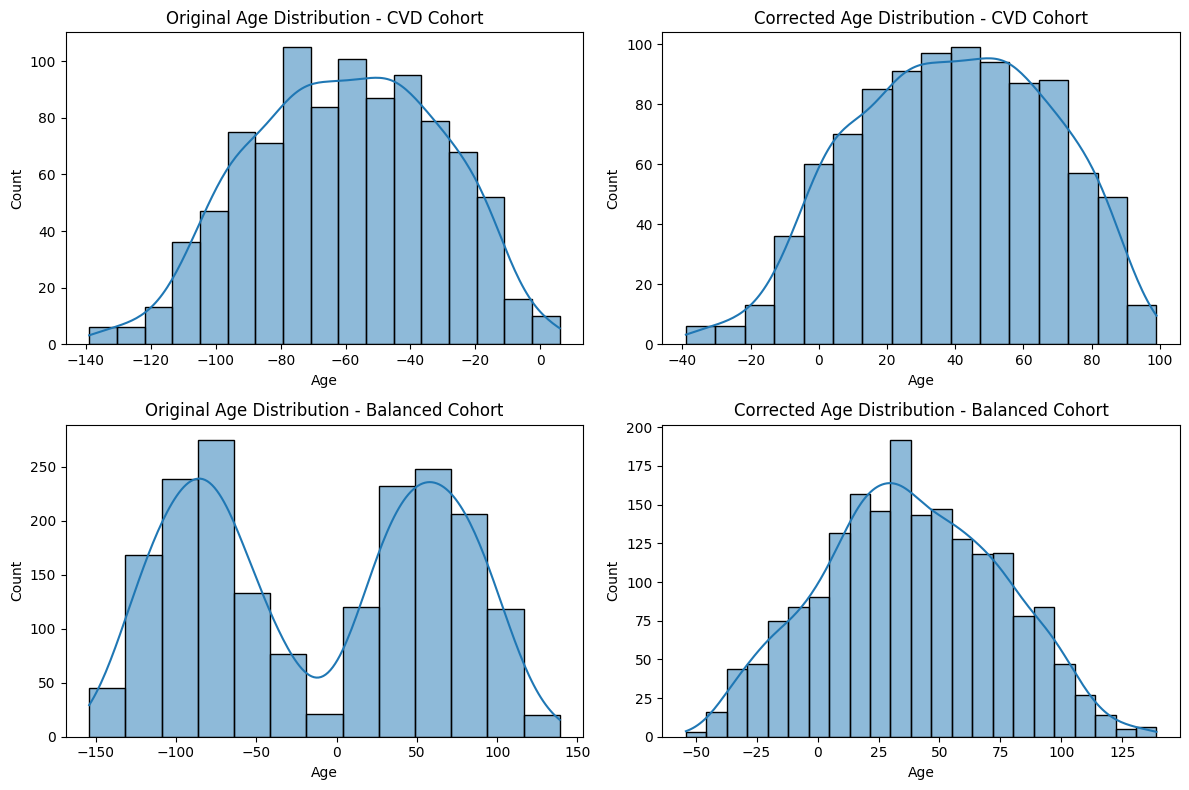

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the original cohorts
mimic_cvd_path = 'mimic_cvd_cohort_with_ids.csv'
mimic_balanced_path = 'mimic_balanced_cohort_with_ids.csv'

cvd_cohort = pd.read_csv(mimic_cvd_path)
balanced_cohort = pd.read_csv(mimic_balanced_path)

# Print original age statistics
print("Original age statistics (CVD cohort):")
print(cvd_cohort['age'].describe())

print("\nOriginal age statistics (balanced cohort):")
print(balanced_cohort['age'].describe())

# Function to correct age based on a more nuanced approach
def correct_age(original_age, current_year=2025):
    # For negative ages (which indicate future birth years)
    if original_age < 0:
        # Calculate implied birth year from negative age
        implied_birth_year = current_year - original_age
        
        # If the birth year is in the future (>2025), subtract 100 years
        if implied_birth_year > 2025:
            adjusted_birth_year = implied_birth_year - 100
            return current_year - adjusted_birth_year
        else:
            # If already in the past, use as is
            return -original_age
    else:
        # For already positive ages, keep as is
        return original_age

# Apply the corrected age calculation
print("\nCorrecting ages with nuanced approach...")
cvd_cohort['age_corrected'] = cvd_cohort['age'].apply(correct_age)
balanced_cohort['age_corrected'] = balanced_cohort['age'].apply(correct_age)

# Display corrected age statistics
print("\nCorrected age statistics (CVD cohort):")
print(cvd_cohort['age_corrected'].describe())

print("\nCorrected age statistics (balanced cohort):")
print(balanced_cohort['age_corrected'].describe())

# Create histograms to visualize the corrected distributions
plt.figure(figsize=(12, 8))

# CVD cohort - before and after
plt.subplot(2, 2, 1)
sns.histplot(cvd_cohort['age'], kde=True)
plt.title('Original Age Distribution - CVD Cohort')
plt.xlabel('Age')

plt.subplot(2, 2, 2)
sns.histplot(cvd_cohort['age_corrected'], kde=True)
plt.title('Corrected Age Distribution - CVD Cohort')
plt.xlabel('Age')

# Balanced cohort - before and after
plt.subplot(2, 2, 3)
sns.histplot(balanced_cohort['age'], kde=True)
plt.title('Original Age Distribution - Balanced Cohort')
plt.xlabel('Age')

plt.subplot(2, 2, 4)
sns.histplot(balanced_cohort['age_corrected'], kde=True)
plt.title('Corrected Age Distribution - Balanced Cohort')
plt.xlabel('Age')

plt.tight_layout()
plt.savefig('age_correction_comparison.png')

# Update the age columns with corrected values
cvd_cohort['age'] = cvd_cohort['age_corrected']
balanced_cohort['age'] = balanced_cohort['age_corrected']

# Drop the temporary columns
cvd_cohort.drop('age_corrected', axis=1, inplace=True)
balanced_cohort.drop('age_corrected', axis=1, inplace=True)

# Final check for extreme values
max_reasonable_age = 105
print(f"\nAdjusting any remaining extreme ages (>{max_reasonable_age})...")

# Cap any remaining extreme ages
cvd_cohort['age'] = cvd_cohort['age'].apply(lambda x: min(x, max_reasonable_age))
balanced_cohort['age'] = balanced_cohort['age'].apply(lambda x: min(x, max_reasonable_age))

# Print final statistics
print("\nFinal age statistics (CVD cohort):")
print(cvd_cohort['age'].describe())

print("\nFinal age statistics (balanced cohort):")
print(balanced_cohort['age'].describe())

# Save the properly corrected datasets
print("\nSaving corrected datasets...")
cvd_cohort.to_csv('mimic_cvd_cohort_corrected.csv', index=False)
balanced_cohort.to_csv('mimic_balanced_cohort_corrected.csv', index=False)

print("Corrected datasets saved as 'mimic_cvd_cohort_corrected.csv' and 'mimic_balanced_cohort_corrected.csv'")

Feature Statistics Comparison:
 Feature Cleveland Mean Cleveland Std MIMIC CVD Mean MIMIC CVD Std MIMIC CVD % Diff MIMIC Balanced Mean MIMIC Balanced Std MIMIC Balanced % Diff
     age          54.44          9.04          39.03         28.38           -28.3%               37.84              36.01                -30.5%
     sex           0.68          0.47           0.55          0.50           -19.6%                0.51               0.50                -25.1%
trestbps         131.69         17.60         137.39         26.14             4.3%              134.26              23.42                  2.0%
    chol         246.69         51.78         178.66         49.49           -27.6%              180.16              47.28                -27.0%
 thalach         149.61         22.88         100.09         23.38           -33.1%               95.56              20.79                -36.1%

Feature distributions have been saved to 'feature_distributions_comparison.png'
Comparison table h

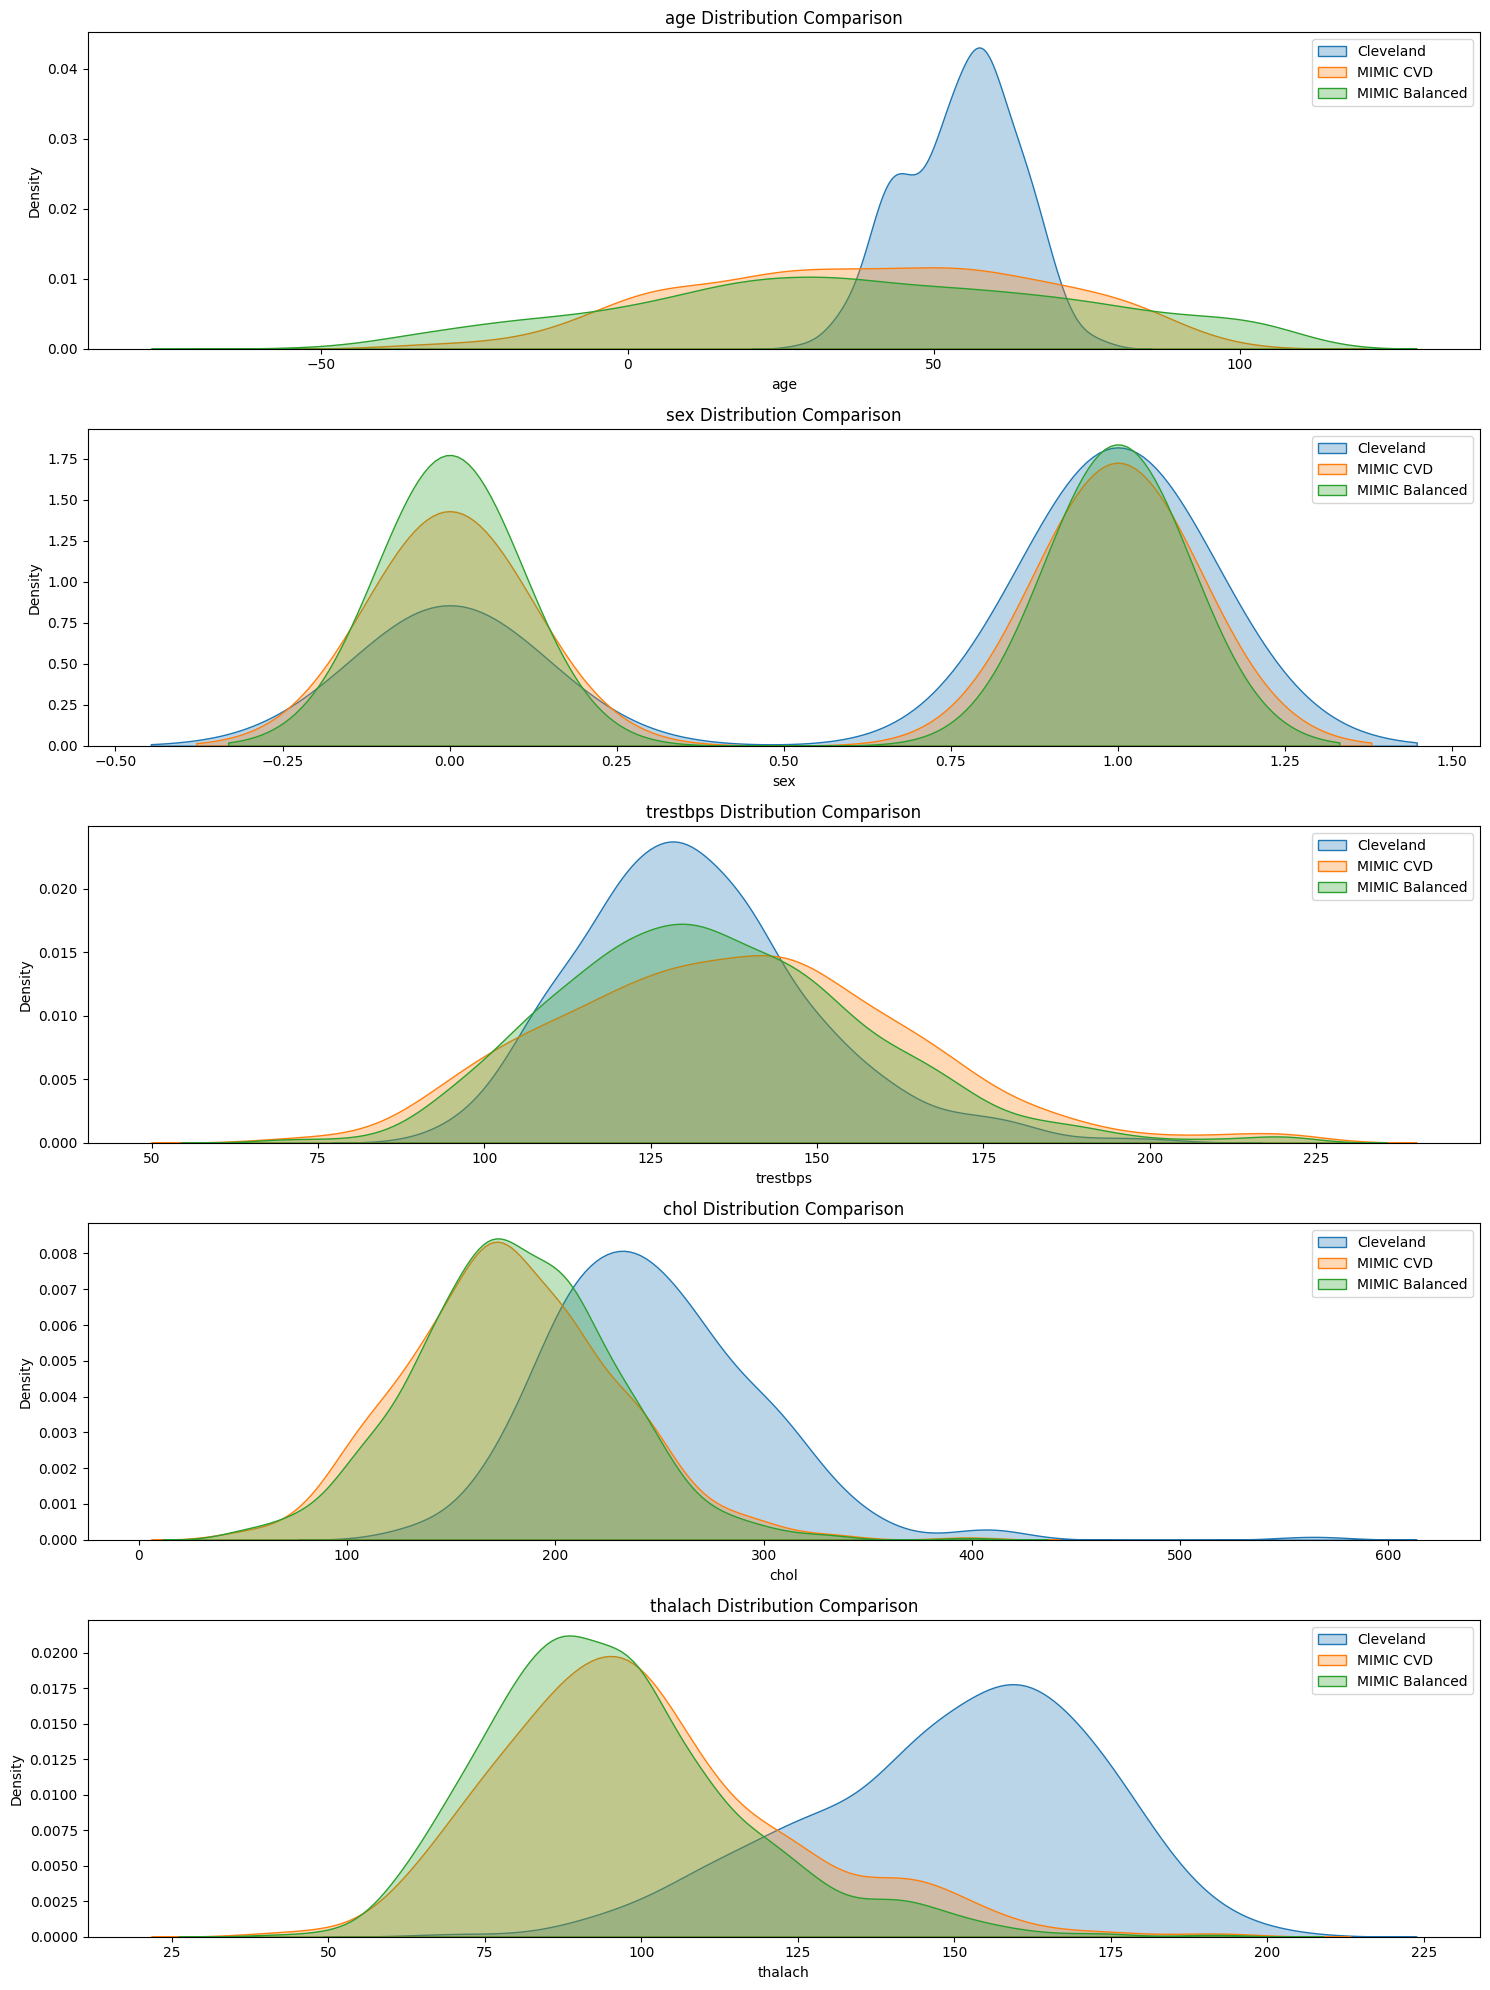

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the corrected MIMIC datasets
mimic_cvd_path = 'mimic_cvd_cohort_corrected.csv'
mimic_balanced_path = 'mimic_balanced_cohort_corrected.csv'

# Load the Cleveland dataset
cleveland_path = '/Users/andrechu/Desktop/UnivUtah/BMI6106/Project/heart+disease/processed.cleveland.data'
cleveland_columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
                    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

# Load the datasets
mimic_cvd = pd.read_csv(mimic_cvd_path)
mimic_balanced = pd.read_csv(mimic_balanced_path)

# Load Cleveland dataset
try:
    # Try comma-separated format first
    cleveland = pd.read_csv(cleveland_path, names=cleveland_columns, na_values='?')
except:
    # If that fails, try space-separated format
    cleveland = pd.read_csv(cleveland_path, names=cleveland_columns, 
                            delim_whitespace=True, na_values='?')

# Ensure target is binary in Cleveland
cleveland['target'] = cleveland['target'].apply(lambda x: 1 if x > 0 else 0)

# Define the key features for comparison
key_features = ['age', 'sex', 'trestbps', 'chol', 'thalach']

# Create a comparison dataframe for key features
comparison_data = []

for feature in key_features:
    # Calculate statistics for each dataset
    clev_mean = cleveland[feature].mean()
    clev_std = cleveland[feature].std()
    
    cvd_mean = mimic_cvd[feature].mean()
    cvd_std = mimic_cvd[feature].std()
    
    balanced_mean = mimic_balanced[feature].mean()
    balanced_std = mimic_balanced[feature].std()
    
    # Calculate percentage difference from Cleveland
    cvd_pct_diff = ((cvd_mean - clev_mean) / clev_mean) * 100
    balanced_pct_diff = ((balanced_mean - clev_mean) / clev_mean) * 100
    
    comparison_data.append({
        'Feature': feature,
        'Cleveland Mean': f"{clev_mean:.2f}",
        'Cleveland Std': f"{clev_std:.2f}",
        'MIMIC CVD Mean': f"{cvd_mean:.2f}",
        'MIMIC CVD Std': f"{cvd_std:.2f}",
        'MIMIC CVD % Diff': f"{cvd_pct_diff:.1f}%",
        'MIMIC Balanced Mean': f"{balanced_mean:.2f}",
        'MIMIC Balanced Std': f"{balanced_std:.2f}",
        'MIMIC Balanced % Diff': f"{balanced_pct_diff:.1f}%"
    })

comparison_df = pd.DataFrame(comparison_data)
print("Feature Statistics Comparison:")
print(comparison_df.to_string(index=False))

# Create distribution plots for each feature
plt.figure(figsize=(15, 20))

for i, feature in enumerate(key_features):
    plt.subplot(5, 1, i+1)
    
    # Plot distributions
    sns.kdeplot(cleveland[feature].dropna(), label='Cleveland', fill=True, alpha=0.3)
    sns.kdeplot(mimic_cvd[feature].dropna(), label='MIMIC CVD', fill=True, alpha=0.3)
    sns.kdeplot(mimic_balanced[feature].dropna(), label='MIMIC Balanced', fill=True, alpha=0.3)
    
    plt.title(f'{feature} Distribution Comparison')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.savefig('feature_distributions_comparison.png')

# Save the comparison table
comparison_df.to_csv('feature_comparison.csv', index=False)

print("\nFeature distributions have been saved to 'feature_distributions_comparison.png'")
print("Comparison table has been saved to 'feature_comparison.csv'")

# Check for any remaining extreme values or data issues
print("\nChecking for remaining data issues...")

for dataset_name, dataset in [("Cleveland", cleveland), ("MIMIC CVD", mimic_cvd), ("MIMIC Balanced", mimic_balanced)]:
    print(f"\n{dataset_name} dataset issues:")
    
    for feature in key_features:
        # Check for negative values (except age which can be negative in some cases)
        if feature != 'age':
            neg_count = (dataset[feature] < 0).sum()
            if neg_count > 0:
                print(f"  {feature}: {neg_count} negative values")
        
        # Check for extreme values
        if feature == 'age':
            extreme = (dataset[feature] > 105).sum()
            if extreme > 0:
                print(f"  {feature}: {extreme} values > 105")
        elif feature == 'trestbps':  # Blood pressure
            extreme = (dataset[feature] > 220).sum()
            if extreme > 0:
                print(f"  {feature}: {extreme} values > 220 mmHg")
        elif feature == 'chol':  # Cholesterol
            extreme = (dataset[feature] > 500).sum()
            if extreme > 0:
                print(f"  {feature}: {extreme} values > 500 mg/dL")
        elif feature == 'thalach':  # Max heart rate
            extreme = (dataset[feature] > 220).sum()
            if extreme > 0:
                print(f"  {feature}: {extreme} values > 220 bpm")
        
        # Check for missing values
        missing = dataset[feature].isna().sum()
        if missing > 0:
            print(f"  {feature}: {missing} missing values ({missing/len(dataset)*100:.1f}%)")

print("\nAnalysis complete!")